## <font style="font-family:roboto;color:#455e6c"> Microstructure Evolution and workflows in computational materials science</font>  

<div class="admonition note" name="html-admonition" style="background:#e3f2fd; padding: 10px">
<font style="font-family:roboto;color:#455e6c"> IUC07 Beyond 3D: Tools for tracking spatiotemporal microstructure evolution </font> </br>
</div>

<table style="table-layout:fixed; width:100%; border-collapse:collapse;">
  <tr>
    <td style="width:25%; border:1px solid #ccc; text-align:center; padding:10px;">
      <img src="images/kanapy_Logo.png" style="max-width:70%; height:auto;">
    </td>
    <td style="width:25%; border:1px solid #ccc; text-align:center; padding:10px;">
      <img src="images/DAMASK_banner.png" style="max-width:70%; height:auto;">
    </td>
    <td style="width:25%; border:1px solid #ccc; text-align:center; padding:10px;">
      <img src="images/Pyiron_workflow_Logo.png" style="max-width:70%; height:auto;">
    </td>
    <td style="width:25%; border:1px solid #ccc; text-align:center; padding:10px;">
      <img src="images/Logo_NFDI-MatWerk.png" style="max-width:70%; height:auto;">
    </td>
  </tr>
</table>

### <font style="font-family:roboto;color:#455e6c"> Introduction </font>

A central challenge in microstructure modeling is that different simulation tools store and represent data in incompatible formats. This fragmentation makes it difficult to build end-to-end workflows where the output of one tool becomes the input of another. The problem becomes even more pronounced when tracking microstructure evolution, since most tools only record their own internal state and lack a common structure for storing time-dependent changes in grains, phases, and voxel fields.

Integrated tools used in this notebook
- Kanapy: generates synthetic 3D microstructures and performs statistical analysis
- DAMASK: performs mechanical simulations based on FFT solver with crystal-plasticity model
- Pyiron_workflow: constructs workflows as computational graphs

This notebook demonstrates how to construct and execute a complete microstructure-to-simulation workflow. The steps include:

- Reading and analysing an electron backscatter diffraction (EBSD) map
- Extracting statistical descriptors from the microstructure
- Generating a 3D microstructure statistically equivalent to the EBSD data
- Exporting the structure to DAMASK as a FAIR-DO object
- Running a cold-rolling simulation in DAMASK
- Capturing microstructure evolution by updating the FAIR-DO object at selected time steps
- Re-analysing the resulted microstructure with Kanapy and comparing it to the initial state
  
The concrete benefits of this workflow: 
The workflow creates a unified, automated chain from microstructure generation to mechanical simulation and post-processing. The FAIR-DO format ensures that results are reusable, traceable, and preserved over time. Automated data exchange removes manual file handling, and the modular node structure makes the workflow adaptable to a wide range of simulation tasks.

### <font style="font-family:roboto;color:#455e6c"> Setting up the core dependencies required for the workflow</font>

In [1]:
# =========================
# Standard library modules
# =========================
import logging
logging.disable(logging.WARNING)

import os
import sys
import io
import re
import json
import time
import shutil
import hashlib
import platform
import subprocess
from datetime import datetime
from pathlib import Path  # (deduped)
from copy import deepcopy
from typing import Union, Sequence, List, Dict, Any, Optional, Tuple, Literal
from collections import defaultdict, deque

# =========================
# Third-party libraries
# =========================
import numpy as np
import numpy.ma as ma
from scipy.stats import lognorm
import pandas as pd
import pyvista as pv
pv.set_jupyter_backend("static")
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
from matplotlib.transforms import Bbox
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
import seaborn as sns
from copy import deepcopy
import h5py
import yaml                                                

from pyiron_workflow import Workflow
import kanapy as knpy
import damask
import orix
from orix.quaternion import Orientation
from orix.quaternion import Rotation
# =========================
# Console formatting (ANSI)
# - Use OLD for bold, RESET to clear styles
# - Colors: CYAN / YELLOW / RED
# =========================
OLD    = "\033[1m"
CYAN   = "\033[1;36m"
YELLOW = "\033[1;33m"
RED    = "\033[1;31m"
GREEN  = "\033[1;32m"
RESET  = "\033[0m"
ColorMode = Literal["grain_id", "ipf_rgb"]
ColorBy = Literal["grain_id", "voxel_id", "euler_phi1"]

### <font style="font-family:roboto;color:#455e6c"> From EBSD Map to 3D Microstructure Using Kanapy (Kanapy sub-workflow)</font>

The first part of this workflow prepares the microstructure that will later be used for simulation. We start from a 2D EBSD scan and use Kanapy to convert it into a simulation-ready 3D RVE (representative volume element).
This requires four core steps: locating the EBSD file, reading and interpreting the scan, reconstructing grains, and finally generating the 3D voxelized microstructure.
These steps ensure that the input structure is physically meaningful, statistically accurate, and compatible with downstream tools such as DAMASK or OpenPhase.
The goal is to standardize the transition from raw EBSD data to a fully defined 3D microstructure that fits seamlessly into a multi-software workflow.

<table style="table-layout:fixed; width:100%; border-collapse:collapse;">
  <tr>
    <!-- 1) EBSD map (Steps 1–3) -->
    <td style="width:20%; border:1px solid #ccc; text-align:center; padding:10px;">
      <img src="images/EBSD.png" style="max-width:70%; height:auto;">
      <div style="margin-top:8px; font-size:12px; color:#444;">
        Steps 1–3:<br>Locate, read &amp; analyse EBSD map
      </div>
    </td>
    <!-- 2) Arrow: generate 3D RVE -->
    <td style="width:10%; border:1px solid #ccc; text-align:center; padding:10px;">
      <div style="font-size:40px; line-height:1;">&#8594;</div>
      <div style="margin-top:8px; font-size:12px; color:#444;">
        Generate 3D RVE
      </div>
    </td>
    <!-- 3) Synthetic microstructure (RVE) (Step 4) -->
    <td style="width:20%; border:1px solid #ccc; text-align:center; padding:10px;">
      <img src="images/Synthetic microstrcuture.png" style="max-width:70%; height:auto;">
      <div style="margin-top:8px; font-size:12px; color:#444;">
        Step 4:<br>3D synthetic microstructure (RVE)
      </div>
    </td>
    <!-- 4) Arrow: export as data object -->
    <td style="width:10%; border:1px solid #ccc; text-align:center; padding:10px;">
      <div style="font-size:40px; line-height:1;">&#8594;</div>
      <div style="margin-top:8px; font-size:12px; color:#444;">
        Export as<br>data object
      </div>
    </td>
    <!-- 5) Data schema / FAIR Data Object (Step 5) -->
    <td style="width:20%; border:1px solid #ccc; text-align:center; padding:10px;">
      <img src="images/data_structure.png" style="max-width:70%; height:auto;">
      <div style="margin-top:8px; font-size:12px; color:#444;">
        Step 5:<br>FAIR data object (JSON schema)
      </div>
    </td>
  </tr>
</table>


#### **Step 1 — Load and read the EBSD map**

Here the EBSD file is parsed and converted into a structured object that Kanapy can work with.
The reader extracts orientations, phase information, and grain labels.
The goal is to turn a raw EBSD scan into a clean data container.

In [2]:
###########################################################################
################### Load and read EBSD map using Kanapy ###################
###########################################################################
@Workflow.wrap.as_function_node("knpyObject")
def load_ebsd_map(file_path: Union[str, Path], show_plot: bool = False):
    """
    Load an EBSD map using Kanapy from `file_path`.

    Parameters
    ----------
    file_path : str or Path
        Relative or absolute path to the EBSD file (e.g., .ang, .ctf).
    show_plot : bool
        Whether to display the figures of EBSD map processing.

    Returns
    -------
    kanapy.EBSDmap
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD} Loading EBSD map ....................................................................{RESET}")
    print("\n\n")

    # Current directory
    cwd = os.getcwd()

    # Full path = current directory + provided file name
    full_path = os.path.join(cwd, file_path)

    # Check existence
    if not os.path.exists(full_path):
        print(f"{RED}{OLD}ERROR: EBSD file not found in current directory.{RESET}")
        print(f"{YELLOW}{OLD}  -> Current working directory: {cwd}{RESET}")
        print(f"{YELLOW}{OLD}  -> Expected file: {file_path}{RESET}")
        raise FileNotFoundError(f"File '{file_path}' does not exist in the current directory.")

    # Load via Kanapy
    ebsd = knpy.EBSDmap(full_path, show_plot)
    
    print(f"{GREEN}{OLD}EBSD file loaded successfully!{RESET}")
    print(f"{YELLOW}{OLD}  -> Current working directory: {cwd}{RESET}")
    print(f"{YELLOW}{OLD}  -> EBSD file: {file_path}{RESET}")
    
    print("\n\n")
    print(f"{YELLOW}{OLD}EBSD map loading is completed ........................................................{RESET}")
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print("\n\n")
    
    return ebsd

#### **Step 2 — Extract statistical descriptors from the EBSD map**

This step computes the microstructural statistics required for generating a 3D synthetic microstructure.
Kanapy needs distributions for grain size, aspect ratio, and grain-shape orientation (tilt angle). These statistical descriptors form the foundation for Kanapy's 3D reconstruction.
They ensure that the synthetic microstructure preserves the key statistical characteristics of the original EBSD map.

In [3]:
#####################################################################################################
#################### Extract statistical parameters from EBSD map or a JSON file ####################
#####################################################################################################
@Workflow.wrap.as_function_node("statisticalDescriptors")
def get_stats(source, NVoxels: int = 25, sizeRVE: int = 25, periodic: bool = True) -> Union[Dict[str, Any], List[Dict[str, Any]]]:
    """
    Extract statistical microstructure descriptors from an EBSD map or a JSON file.
    
    Parameters
    ----------
    source : str or Path or EBSDmap
        Either a JSON file containing precomputed statistics or a Kanapy
        EBSDmap object from which statistics will be computed.
    NVoxels : int, optional
        Number of voxels per axis used for discretization.
        Default is 25.
    sizeRVE : int, optional
        Target physical size of the representative volume element (RVE).
        Default is 25.
    periodic : bool, optional
        Whether the generated RVE should be periodic. Default is True.

    Returns
    -------
    dict or list of dict
        - For JSON input: whatever structure is returned by ``knpy.import_stats``.
        - For EBSD input with one phase: a single statistics dictionary.
        - For EBSD input with multiple phases: a list of statistics dictionaries,
          one per phase, suitable for use as
          ``knpy.Microstructure(descriptor=[ms_stats_0, ms_stats_1, ...])``.
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Extracting microstructure statistics .................................................{RESET}")
    print("\n\n")
    
    # -------------------------------------------------------------------------
    # Case 1: If the source is a JSON file, import precomputed statistics
    # -------------------------------------------------------------------------
    if isinstance(source, (str, Path)):
        src = str(source)
        if not src.lower().endswith(".json"):
            raise ValueError("Only JSON files can be imported as statistical parameters.")
        if not os.path.isfile(src):
            raise FileNotFoundError(f"The specified JSON file '{src}' does not exist.")
        try:
            ms_stats = knpy.import_stats(src)
        except Exception as error:
            raise ValueError(f"Error reading JSON file '{src}': {error}")

    # -------------------------------------------------------------------------
    # Case 2: If the source is Kanapy EBSDmap-like object, compute statistics
    # -------------------------------------------------------------------------
    else:
        # Validation for expected attributes
        if not hasattr(source, "ms_data"):
            raise ValueError("Invalid EBSD map object: missing attribute 'ms_data'.")

        ms_data_list = source.ms_data
        if not ms_data_list:
            raise ValueError("EBSD map object contains empty 'ms_data'.")

        phase_descriptors = []

        try:
            for ph_index, ph_data in enumerate(ms_data_list):
                # Normalize phase name: lowercase + underscores
                matname = ph_data["name"].lower().replace(" ", "_")

                gs_param = ph_data["gs_param"]  # log-normal parameters for grain size
                ar_param = ph_data["ar_param"]  # log-normal parameters for aspect ratios
                om_param = ph_data["om_param"]  # normal distribution for tilt angles

                # Compute statistics for this phase using Kanapy
                phase_stats = knpy.set_stats(
                    gs_param,
                    ar_param,
                    om_param,
                    deq_min=5.0, deq_max=13.0,
                    asp_min=0.95, asp_max=3.5,
                    omega_min=0.0, omega_max=np.pi,
                    voxels=NVoxels,
                    size=sizeRVE,
                    periodicity=periodic,
                    VF=ph_data["vf"],
                    phasename=matname,
                    phasenum=ph_index,
                )

                # Attach raw data for traceability (optional but useful)
                phase_stats["Data"] = {
                    "grain_size": ph_data.get("gs_data"),
                    "aspect_ratio": ph_data.get("ar_data"),
                }

                phase_descriptors.append(phase_stats)

        except (KeyError, IndexError, AttributeError) as exc:
            raise ValueError(f"EBSD map object is missing expected fields: {exc}")

        # For single-phase case, keep backward-compatible behavior
        if len(phase_descriptors) == 1:
            ms_stats = phase_descriptors[0]
        else:
            ms_stats = phase_descriptors

    print("\n\n")
    print(f"{YELLOW}{OLD}Microstructure statistics extracting is completed .................................{RESET}")
    print(f"{CYAN}{OLD}#####################################################################################{RESET}")
    print("\n\n")
    
    return ms_stats

#### **Step 3 — Generate the 3D synthetic microstructure**

This step uses the statistical descriptors to build a fully defined 3D representative volume element. Kanapy first creates a simulation box and fills it with ellipsoidal grains that follow the target grain-size, aspect-ratio, and orientation distributions. The grains are packed, voxelized into a regular 3D grid, and then assigned crystallographic orientations—either synthetic (Goss, Copper, random) or derived from a custom orientation distribution.
The result is a voxelized, physically consistent 3D microstructure ready for crystal-plasticity or phase-field simulations.

In [4]:
######################################################################################################
#################### create an RVE for simulating the microstructure of materials ####################
######################################################################################################
@Workflow.wrap.as_function_node("RVE")
def generate_rve(source: Union[Dict[str, Any], List[Dict[str, Any]]], ori, show_plots: bool = True) -> knpy.Microstructure:
    """
    Construct a 3D representative volume element (RVE) from microstructure
    statistical descriptors and assign crystallographic orientations.

    Parameters
    ----------
    source : dict
        Microstructure descriptor produced by ``knpy.set_stats`` or an equivalent
        workflow step. Must contain phase information, geometric statistics, and
        voxelization settings under keys such as ``"Phase"``, ``"Equivalent diameter"``,
        ``"Aspect ratio"``, and ``"RVE"``.
    ori : str or object
        Orientation specification for the generated RVE. Accepted values:
        - "goss"     → unimodal Goss texture
        - "copper"   → unimodal Copper texture
        - "random"   → fully random texture
        - orientation object (e.g. EBSD-derived ODF) for custom textures
    show_plots : bool, optional
        If True, display ellipsoid packing, voxelization slices, initial statistics,
        and orientation-colored voxel maps. Default is True.

    Returns
    -------
    knpy.Microstructure
        A fully generated microstructure object containing:
        - packed ellipsoidal grains,
        - voxelized 3D grid representation,
        - assigned crystallographic orientations,
        - plotting and export utilities for downstream simulations.
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Generating RVE .......................................................................{RESET}")
    print("\n\n")
    
    if isinstance(source, dict):
        descriptor = source
        phase_block = source.get("Phase") or {}
        # Use phase name if present, otherwise a neutral default
        material_name = phase_block.get("Name") or "RVE"
    elif isinstance(source, list):
        descriptor = source

        phase_names = []
        for ph in source:
            if isinstance(ph, dict):
                ph_block = ph.get("Phase") or {}
                ph_name = ph_block.get("Name")
                if ph_name:
                    phase_names.append(ph_name)
        if phase_names:
            material_name = "_".join(phase_names)
        else:
            material_name = "multi_phase_RVE"
    else:
        raise ValueError(
            "`source` must be a dict or a list of dicts "
            "(e.g., output of get_stats / knpy.set_stats)."
        )

    # -------------------------------------------------------------------------
    # 1) Create simulation box with ellipsoidal grains
    # -------------------------------------------------------------------------
    ms = knpy.Microstructure(descriptor=source, name=f"{material_name}_RVE")
    ms.init_RVE()
    # Creates particle distribution (within the given lower and upper bounds)
    # inside simulation box (RVE) based on the data provided in the data file
    # -------------------------------------------------------------------------

    # -------------------------------------------------------------------------
    # 2) Perform particle packing 
    # -------------------------------------------------------------------------
    ms.pack()
    print("\n\n")
    if show_plots:
        ms.plot_ellipsoids()
    # Simulates grain packing in the box. Particles are initially downscaled
    # to avoid overlap and allow free movement. Collisions are handled during packing.
    # ---------------------------------------------------------------------------------

    # -------------------------------------------------------------------------
    # 3) Voxelize to 3D grid 
    # -------------------------------------------------------------------------
    ms.voxelize()
    print("\n\n")
    if show_plots:
        ms.plot_voxels(sliced=True)
    # Converts the packed structure into a voxelated 3D mesh.
    #   Voxels inside grains are assigned to the grain phase, while others
    #   are filled according to a grain growth algorithm.
    # --------------------------------------------------------------------------
    print("\n\n")
    # Optional: plot initial stats if raw data is present (added in get_stats)
    if show_plots:
        if isinstance(source, dict):
            data_block = source.get("Data", {})
        elif isinstance(source, list) and source and isinstance(source[0], dict):
            data_block = source[0].get("Data", {})
        else:
            data_block = {}

        gs_data = data_block.get("grain_size")
        ar_data = data_block.get("aspect_ratio")
        if gs_data is not None and ar_data is not None:
            ms.plot_stats_init(gs_data=gs_data, ar_data=ar_data)

    # -------------------------------------------------------------------------
    # 4 - Assign orientations to grains 
    # -------------------------------------------------------------------------
    if isinstance(ori, str):
        key = ori.lower().strip()
        if key == "goss":
            ang, omega, texture_desc = [0, 45, 0], 7.5, "unimodel"
        elif key == "copper":
            ang, omega, texture_desc = [90, 35, 45], 7.5, "unimodel"
        elif key == "random":
            ang, omega, texture_desc = None, None, "random"
        else:
            raise ValueError('Unsupported texture string in `ori`. Use "goss", "copper", or "random".')

        ms.generate_orientations(texture_desc, ang=ang, omega=omega, hist=None, Nbase=1000)
    else:
        # Custom orientation object (e.g., EBSD-derived ODF) or None
        ms.generate_orientations(ori) # downsample ODF of EBSD map to actual number of grains
    print("\n\n") 
    
    if show_plots:
        ms.plot_voxels(ori=True)  # plot voxelized grains in color code of IPF key

    print("\n\n")
    print(f"{YELLOW}{OLD}RVE generating is completed ........................................................{RESET}")
    print(f"{CYAN}{OLD}######################################################################################{RESET}")
    print("\n\n")
    
    return ms # Return the generated microstructure object

#### **Step 4 — Export the microstructure as a FAIR Data Object**

This step converts the generated RVE into a FAIR Data Object: a single JSON file that consolidates everything required for downstream simulation.
The function collects the voxelized microstructure, adds the user metadata, boundary conditions, phases, and units, checks the grain orientations, and then builds the complete FAIR Data Object that contains the following sections:
- User information
- System environment
- Job setup
- Property outputs
- microstructural data

The result is a standardized, interoperable data object that can be consumed reliably by other tools—such as DAMASK; the workflow remains transparent, reusable, and fully aligned with FAIR data principles.

In [5]:
##################################################################################################################
#################### write the data json file containing all the data required the simulation ####################
##################################################################################################################
@Workflow.wrap.as_function_node("dataObject", "pathtoDataObject")
def write_data( source: knpy.Microstructure, user_metadata: dict, boundary_condition: dict, phases: list, units: dict):
    """
    Build and save a JSON data object from a Kanapy microstructure.

    The function serializes a voxelized RVE produced by Kanapy into a JSON
    data object compatible with the microstructure-sensitive mechanical
    metadata schema. It validates basic inputs, delegates core schema
    construction to ``source.write_dataSchema``, enriches the result
    with system/software metadata, and installs phase-wise Euler angle
    arrays derived from the grain orientations.

    Parameters
    ----------
    source : knpy.Microstructure
        Voxelized RVE (Kanapy microstructure object) to be serialized.
        Must provide a ``write_dataSchema`` method with the signature used
        below.
    user_metadata : dict
        User and project metadata to embed in the data schema (e.g.,
        creator, affiliation, ORCID, title).
    boundary_condition : dict
        Boundary-condition block describing the mechanical or loading
        conditions to be used by the solver (e.g., strain/strain-rate
        control, periodic BC flags).
    phases : list of dict
        List of phase descriptors passed through to
        ``source.write_dataSchema``. Each entry typically encodes phase
        name, phase ID, material parameters, and crystal structure.
    units : dict
        Mapping of physical quantities to units, e.g.
        ``{"length": "um", "stress": "MPa"}``. A ``"length"`` entry is
        mandatory and is used to set ``length_unit`` when calling
        ``write_dataSchema``.

    Returns
    -------
    dict
        The full data object written to disk, including:
        core schema returned by ``write_dataSchema``,
        the original ``units`` block,
        system/software metadata,
        and phase-wise Euler angle arrays.
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Exporting data .......................................................................{RESET}")
    print("\n\n")
    # -------------------------------------------------------------------------
    # 1) Validate basic inputs 
    # -------------------------------------------------------------------------
    if not isinstance(user_metadata, dict):
        raise ValueError("user_metadata must be a dict")
    if not isinstance(boundary_condition, dict):
        raise ValueError("boundary_condition must be a dict")
    if not isinstance(phases, (list, tuple)):
        raise ValueError("phases must be a list/tuple")
    if not isinstance(units, dict):
        raise ValueError("units must be a dict")
        
    units_norm = {str(k).lower(): v for k, v in units.items()}
    length_unit = units_norm.get("length")
    if length_unit is None:
        length_unit = units.get("Length") or units.get("LENGTH")
    if length_unit is None:
        raise ValueError("units must contain a 'length' entry (e.g., {'length':'um'})")

    # -------------------------------------------------------------------------    
    # 2) Build data structure via Kanapy
    # -------------------------------------------------------------------------
    data = source.write_data(
        user_metadata=user_metadata,
        boundary_condition=boundary_condition,
        phases=phases,
        interactive=False,
        structured=True,
        length_unit=length_unit,
    )
    
    if not isinstance(data, dict) or not data:
        raise RuntimeError("write_dataSchema did not return a non-empty dict.")
    data["units"] = units # Add units to the data schema
    data["date"] = str(datetime.utcnow().strftime("%Y-%m-%d"))
    # -------------------------------------------------------------------------
    # 3) Locate grains robustly and validate orientations
    # -------------------------------------------------------------------------
    evo = data.get("microstructure")
    # If evo came back as a list, accept [ {...} ] as well
    if isinstance(evo, list):
        if len(evo) == 1 and isinstance(evo[0], dict):
            evo = evo[0]
        else:
            raise ValueError("Expected 'microstructure' as dict or single-element list of dict.")
    if not isinstance(evo, dict):
        raise ValueError("Missing or invalid 'microstructure' block (dict expected).")

    grains = evo.get("grains")
    if not isinstance(grains, list) or len(grains) == 0:
        raise ValueError("Missing or invalid 'grains' list inside 'microstructure'.")

    # Validate each grain has orientation [Phi1, Phi, Phi2]
    for i, g in enumerate(grains):
        if not isinstance(g, dict):
            raise ValueError(f"Grain at index {i} is not a dict: {type(g).__name__}")
        ori = g.get("orientation")
        if not (isinstance(ori, (list, tuple)) and len(ori) == 3):
            raise ValueError(f"Grain {i} has invalid 'orientation' (need [Phi1, Phi, Phi2]): {ori}")

    # -------------------------------------------------------------------------
    # 4) Update system information
    # -------------------------------------------------------------------------
    # DAMASK information
    data["software"] = "DAMASK"
    data["software_version"] = getattr(damask, "__version__", "unknown")
    
    # System information
    data["system"] =  platform.system() 
    data["system_version"] =  platform.version()   
    data["processor_specifications"] =  platform.processor() or platform.machine()
    
    # Workflow paths: use absolute paths for reproducibility
    inputs_dir = os.path.abspath("inputs")
    outputs_dir = os.path.abspath("outputs")
    os.makedirs(inputs_dir, exist_ok=True)
    os.makedirs(outputs_dir, exist_ok=True)
    data["input_path"] = inputs_dir
    data["results_path"] = outputs_dir
    # -------------------------------------------------------------------------
    # 5) Install Euler arrays in the Phase dict 
    # -------------------------------------------------------------------------
    phases_block = data.get("phases")
    if not isinstance(phases_block, list) or len(phases_block) == 0:
        raise ValueError("Missing or invalid 'phases' list in data object.")
    phase_orient = defaultdict(lambda: {"Phi1": [], "Phi": [], "Phi2": []})

    for i, g in enumerate(grains):
        if "phase_id" not in g:
            raise ValueError(f"Grain {i} is missing 'phase_id'.")
        pid = g["phase_id"]

        ori = g.get("orientation")
        if not (isinstance(ori, (list, tuple)) and len(ori) == 3):
            raise ValueError(
                f"Grain {i} has invalid 'orientation' (need [Phi1, Phi, Phi2]): {ori}"
            )

        phase_orient[pid]["Phi1"].append(ori[0])
        phase_orient[pid]["Phi"].append(ori[1])
        phase_orient[pid]["Phi2"].append(ori[2])

    # Attach Euler arrays to each phase entry
    for idx, p in enumerate(phases_block):
        # Determine phase id for this phase:
        #   - prefer explicit "phase_id" if present
        #   - otherwise fall back to list index
        pid = p.get("phase_id", idx)

        eulers = phase_orient.get(pid)
        if not eulers:
            # No grains for this phase → skip
            continue

        orient_block = p.setdefault("orientation", {})
        euler_dict = orient_block.setdefault("euler_angles", {})

        euler_dict["Phi1"] = eulers["Phi1"]
        euler_dict["Phi"]  = eulers["Phi"]
        euler_dict["Phi2"] = eulers["Phi2"]

        # Number of grains belonging to this phase
        orient_block["grain_count"] = len(eulers["Phi1"])
        # Create orienation identifier for the orientation in this phase
        eulers = np.column_stack([euler_dict["Phi1"], euler_dict["Phi"], euler_dict["Phi2"]])
        eulers = np.round(eulers, decimals=6)
        payload = json.dumps(eulers.tolist(), separators=(",", ":"),sort_keys=False).encode("utf-8")
        h = hashlib.new("sha256")
        h.update(payload)
        orient_block["orientation_identifier"] = h.hexdigest()
    # -------------------------------------------------------------------------
    # 6) Save data object to JSON
    # -------------------------------------------------------------------------
    file_name = "data_object.json"
    out_path = os.path.join(data["results_path"], os.path.basename(file_name))
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2, ensure_ascii=False)
    print("Saved to:", os.path.abspath(out_path))
    
    print("\n\n")
    print(f"{YELLOW}{OLD}Data saved to JSON file ............................................................{RESET}")
    print(f"{CYAN}{OLD}######################################################################################{RESET}")
    print("\n\n")
    
    return data, out_path

### <font style="font-family:roboto;color:#455e6c">From 3D RVE to Simulation and Data updating Using DAMASK (DAMASK sub-workflow)</font>

In the second sub-workflow, the FAIR data object produced by Kanapy is taken as input to set up, run, and feed back a cold rolling simulation in DAMASK.

<table style="table-layout:fixed; width:100%; border-collapse:collapse;">
  <tr>
    <!-- 1) FAIR Data Object from Kanapy -->
    <td style="width:18%; border:1px solid #ccc; text-align:center; padding:10px;">
      <img src="images/data_structure.png" style="max-width:100%; height:auto;">
      <div style="margin-top:8px; font-size:12px; color:#444;">
        FAIR data object<br>(from Kanapy sub-workflow)
      </div>
    </td>
    <!-- Arrow: Load into DAMASK -->
    <td style="width:6%; border:1px solid #ccc; text-align:center; padding:10px;">
      <div style="font-size:30px; line-height:1;">&#8594;</div>
      <div style="margin-top:6px; font-size:11px; color:#444;">
        Loaded by DAMASK
      </div>
    </td>
    <!-- 2) Microstructure evolution (Initial - Deformed - Last step) -->
    <td style="width:52%; border:1px solid #ccc; text-align:center; padding:10px;">
      <div style="display:flex; justify-content:space-between; align-items:center; gap:8px;">
        <div style="flex:1; text-align:center;">
          <div style="margin-bottom:4px; font-size:11px; color:#444;">
            time = 0
          </div>
          <img src="images/Initial microstrcutre copy.png" style="max-width:100%; height:auto;">
        </div>
        <div style="flex:1; text-align:center;">
          <div style="margin-bottom:4px; font-size:11px; color:#444;">
            time = 25
          </div>
          <img src="images/Deformed microstructure copy.png" style="max-width:100%; height:auto;">
        </div>
        <div style="flex:1; text-align:center;">
          <div style="margin-bottom:4px; font-size:11px; color:#444;">
            time = 50
          </div>
          <img src="images/Deformed microstructure at last step copy.png" style="max-width:100%; height:auto;">
        </div>
      </div>
      <!-- Caption under the three images -->
      <div style="margin-top:8px; font-size:12px; color:#444;">
        Microstructure evolution (Initial → Deformed → Last Step)
      </div>
    </td>
    <!-- Arrow: Update FAIR Data Object -->
    <td style="width:6%; border:1px solid #ccc; text-align:center; padding:10px;">
      <div style="font-size:30px; line-height:1;">&#8594;</div>
      <div style="margin-top:6px; font-size:11px; color:#444;">
        Update<br>data object
      </div>
    </td>
    <!-- 3) Updated data object including evolution -->
    <td style="width:18%; border:1px solid #ccc; text-align:center; padding:10px;">
      <img src="images/update data file.png" style="max-width:100%; height:auto;">
      <div style="margin-top:8px; font-size:12px; color:#444;">
        FAIR data object updated<br>with microstructure evolution
      </div>
    </td>
  </tr>
</table>

#### **Step 5 – Prepare DAMASK input files**

The function load_to_damask reads the data (FAIR data object) and automatically builds the three core DAMASK inputs:
a structured FFT grid (grid.vti), 
a phase-consistent material file (material.yaml), 
and a loadcase file (load.yaml) with user-defined deformation history, time stepping, and requested outputs.
Material parameters, constitutive models, elastic constants, and plasticity settings are all derived from

In [6]:
#############################################################################################################
#################### Writing grid, material, and load files to start a DAMASK simulation ####################
#############################################################################################################
@Workflow.wrap.as_function_node("grid", "material", "load")
def load_to_damask(
    source: dict,
    grid_out: Union[str, Path] = "grid.vti",
    material_out: Union[str, Path] = "material.yaml",
    load_out: Union[str, Path] = "load.yaml",
    N_list: Sequence[int] = (100,),      # number of increments per step
    f_out_list: Sequence[int] = (5,),    # write results every f_out increments
    f_restart_list: Sequence[int] = (50,),  # write restart every f_restart increments
    outputs: Sequence[str] = ("F", "P", "F_p", "F_e", "L_p", "O"),
):
    """
    Build DAMASK grid, material, and load files from a schema-like data object.

    This function takes a JSON-like data object (as produced by the
    ``write_data`` step) and generates the three input files required to run
    a DAMASK spectral simulation:

    - a grid file (``GeomGrid``),
    - a material configuration (``ConfigMaterial``),
    - and a loadcase file (``LoadcaseGrid``).

    The function assumes that the input ``source`` is compatible with
    ``damask.GeomGrid.load_kanapy``, ``damask.ConfigMaterial.load_kanapy``,
    and that it contains a ``"mechanical_BC"`` block interpretable by
    ``LoadcaseGrid.from_mechanical_bc``.

    Parameters
    ----------
    source : dict
        Data object containing at least:
        - ``"input_path"`` : str, base directory for input/output files.
        - ``"phases"`` : list of dicts, each with a ``"phase_id"`` key and a
          ``"constitutive_model"`` block that includes at least:
          * ``"elastic_model_name"`` and ``"elastic_parameters"`` (dict),
          * ``"plastic_model_name"`` and ``"plastic_parameters"`` (dict).
        - ``"mechanical_BC"`` : list describing mechanical boundary
          conditions, including ``constraints`` and ``applied_load`` entries
          with ``"duration"`` and ``"magnitude"`` fields.

        Additional keys required by ``GeomGrid.load_kanapy`` and
        ``ConfigMaterial.load_kanapy`` must also be present.
    grid_out : str or pathlib.Path, optional
        Grid file name, relative to ``source["input_path"]``. Default is
        ``"grid.vti"``.
    material_out : str or pathlib.Path, optional
        Material configuration file name, relative to ``source["input_path"]``.
        Default is ``"material.yaml"``.
    load_out : str or pathlib.Path, optional
        Loadcase file name, relative to ``source["input_path"]``.
        Default is ``"load.yaml"``.
    N_list : sequence of int, optional
        Number of increments per load step. Passed directly to
        ``LoadcaseGrid.from_mechanical_bc``.
    f_out_list : sequence of int, optional
        Output stride per load step (results are written every ``f_out``
        increments). Passed directly to ``LoadcaseGrid.from_mechanical_bc``.
    f_restart_list : sequence of int, optional
        Restart stride per load step (restart files are written every
        ``f_restart`` increments). Passed directly to
        ``LoadcaseGrid.from_mechanical_bc``.
    outputs : sequence of str, optional
        Mechanical outputs to request for each phase in the material file,
        e.g. ``("F", "P", "F_p", "F_e", "L_p", "O")``.

    Returns
    -------
    tuple of str
        Absolute paths ``(grid_path, material_path, load_path)`` of the
        generated grid, material, and load files.
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Building grid/material/load from JSON ................................................{RESET}")
    print("\n\n")

    # Ensure we work with strings when joining paths
    base_path = source["input_path"]
    grid_out = os.path.join(base_path, str(grid_out))
    material_out = os.path.join(base_path, str(material_out))
    load_out = os.path.join(base_path, str(load_out))

    # -------------------------------------------------------------------------
    # 1) Grid: build and save GeomGrid
    # -------------------------------------------------------------------------
    grid = damask.GeomGrid.load_MiMedat(source)
    grid.save(str(grid_out))
    print(grid)
    print("grid file Saved to:", grid_out)
    print("\n")

    # -------------------------------------------------------------------------
    # 2) Material: build and save ConfigMaterial
    # -------------------------------------------------------------------------
    material = damask.ConfigMaterial.load_MiMedat(source, outputs)
    material.save(str(material_out))
    print("material file Saved to:", material_out)
    print("\n")

    # -------------------------------------------------------------------------
    # 3) Loadcase: build and save LoadcaseGrid
    # -------------------------------------------------------------------------
    loadcase = damask.LoadcaseGrid.from_mechanical_bc(
        src=source,
        N_list=N_list,
        f_out_list=f_out_list,
        f_restart_list=f_restart_list,
        mechanical_solver="spectral_basic",
    )
    loadcase.save(str(load_out))
    print("load file Saved to:", load_out)
    print("\n")

    grid_path = str(Path(grid_out).resolve())
    material_path = str(Path(material_out).resolve())
    load_path = str(Path(load_out).resolve())

    print("\n\n")
    print(f"{YELLOW}{OLD}Files are written ..................................................................{RESET}")
    print(f"{CYAN}{OLD}######################################################################################{RESET}")
    print("\n\n")

    return grid_path, material_path, load_path

#### **Step 6 – Run the DAMASK simulation**

The function run_damask calls DAMASK_grid with the generated grid, material, and load files.
It validates the input paths, launches the spectral solver, logs the run, and returns the path to the resulting HDF5 file that contains the full field data over all increments.

In [7]:
#########################################################################################################
#################### Running DAMASK simulations using the FFT grid (spectral) solver ####################
#########################################################################################################
@Workflow.wrap.as_function_node("results")
def run_damask( grid_file: Union[str, Path], material_file: Union[str, Path], load_file: Union[str, Path] ) -> str:
    """
    Run DAMASK_grid with the provided grid/material/load files.

    Inputs:
      - grid_file (str|Path): Path to grid (.vti).
      - material_file (str|Path): Path to material (.yaml).
      - load_file (str|Path): Path to loadcase (.yaml).

    Outputs:
      - fn_hdf (str): Path to the produced HDF5 results file.
    """
    print(f"{CYAN}{OLD}#########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Starting Simulation ...................................................................{RESET}")
    print("\n\n")
    
    # 1) Resolve & validate input paths -------------------------------------------------
    fn_geometry = Path(grid_file)
    fn_material = Path(material_file)
    fn_load     = Path(load_file)

    if not fn_geometry.is_file():
        raise FileNotFoundError(f"Geometry file not found: {fn_geometry}")
    if not fn_material.is_file():
        raise FileNotFoundError(f"Material file not found: {fn_material}")
    if not fn_load.is_file():
        raise FileNotFoundError(f"Load file not found: {fn_load}")

    # --- Output directory based on current working directory ---
    cwd = os.getcwd()
    damask_dir = os.path.join(cwd, "outputs")
    os.makedirs(damask_dir, exist_ok=True)
    log_path = os.path.join(damask_dir, "run.log")

    # 2) Build the command --------------------------------------------------------------
    cmd = [
        "DAMASK_grid",
        "-g", str(fn_geometry),
        "-l", str(fn_load),
        "-m", str(fn_material),
    ]
    print("Running:", " ".join(cmd))

    # 3) Launch process & stream output -------------------------------------------------
    with open(log_path, "a", encoding="utf-8") as log:     
        print("Running:", " ".join(cmd), file=log)
        
        process = subprocess.run(
            cmd,
            stdout=log,
            stderr=subprocess.STDOUT,
            text=True,
            check=False,
            cwd=damask_dir,
        )

    # 4) Post-process result ------------------------------------------------------------
    if process.returncode != 0:
        print(f"{RED}{OLD}Error during simulation (non-zero return code){RESET}") 
        fn_hdf = False 
    else:
        print(f"{GREEN}{OLD}Simulation completed successfully{RESET}") 
        # Many DAMASK runs name the HDF5 as "<geom>_<load>_<mat>.hdf5".
        # Use Path.stem to strip extensions robustly (e.g., ".vti", ".yaml").
        out_name = f"{fn_geometry.stem}_{fn_load.stem}_{fn_material.stem}.hdf5"
        fn_hdf = os.path.join(damask_dir, out_name)

    print("\n\n")
    print(f"{YELLOW}{OLD}Simulation is completed ..............................................................{RESET}")
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print("\n\n")
    
    return fn_hdf

#### **Step 7 – Post-process simulation results**

The function post_processing opens the HDF5 result and enriches it with derived quantities (Cauchy stress, logarithmic strain, von Mises stresses, and IPF colors).
It exports VTK files for visualization, computes the RVE-average stress–strain response as well as per-grain curves, saves the plots, and writes the averaged stress–strain data back into a JSON file as part of updating the property part of the data file.
This step links the DAMASK simulation back to a structured data representation.

In [8]:
#########################################################
#################### Post-processing ####################
#########################################################
@Workflow.wrap.as_function_node("UpdatedDataObject")
def post_processing(
    results: Union[str, Path],
    json_path: Union[str, Path],
    quantities: Sequence[str] = ("O", "F", "P", "epsilon_V^0.0(F)"),
    export_vtk: bool = True,):
    """
    Post-process a DAMASK HDF5 result and append selected fields into the JSON
    microstructure time series using Result.export_kanapy().

    Parameters
    ----------
    results : str or pathlib.Path
        Path to DAMASK result HDF5 file.
    json_path : str or pathlib.Path
        Path to the Kanapy-style JSON file to be updated in place.
        Must contain exactly one snapshot (initial undeformed) for export_kanapy().
    quantities : Sequence[str], optional
        DAMASK dataset keys to export (e.g., ("O","F","P","epsilon_V^0.0(F)")).
    export_vtk : bool, optional
        If True, export VTK to outputs/vtk.

    Returns
    -------
    str
        Path to the updated JSON file.
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Start postprocessing .................................................................{RESET}")
    print("\n\n")

    # -------------------------------------------------------------------------
    # 0) Resolve paths & output folders
    # -------------------------------------------------------------------------
    results = Path(results)
    json_path = Path(json_path)

    cwd = Path.cwd()
    out_dir = cwd / "outputs"
    out_dir.mkdir(exist_ok=True)

    if not results.exists():
        raise FileNotFoundError(f"Result file not found: {results}")

    # -------------------------------------------------------------------------
    # 1) Load DAMASK result
    # -------------------------------------------------------------------------
    result = damask.Result(str(results))

    # -------------------------------------------------------------------------
    # 2) Add derived fields (best effort)
    # -------------------------------------------------------------------------
    try:
        result.add_stress_Cauchy("P", "F")               # -> 'sigma'
        result.add_strain("F")                           # -> 'epsilon_V^0.0(F)'
        result.add_equivalent_Mises("sigma")             # -> 'sigma_vM'
        result.add_equivalent_Mises("epsilon_V^0.0(F)")  # -> 'epsilon_V^0.0(F)_vM' (naming depends on DAMASK)
        result.add_IPF_color(l=[1, 0, 0], q="O")          # -> 'IPFcolor_(1 0 0)'
    except ValueError as e:
        print(f"[WARN] Skipping derived-variable addition: {e}")

    # -------------------------------------------------------------------------
    # 3) Optional: export VTK for ParaView
    # -------------------------------------------------------------------------
    if export_vtk:
        vtk_dir = out_dir / "vtk"
        vtk_dir.mkdir(exist_ok=True)
        try:
            result.export_VTK(target_dir=str(vtk_dir))
            print("[OK] Exported VTK to:", vtk_dir)
        except Exception as e:
            print(f"[WARN] VTK export skipped: {e}")

    # -------------------------------------------------------------------------
    # 4) Export JSON (append snapshots)
    # -------------------------------------------------------------------------
    # If user passed a directory, normalize to a file inside it.
    updated_json = result.export_MiMedat(json_path=json_path, quantities=quantities, verbose=True)
    print("[OK] Exported JSON to:", updated_json)
    print("\n")

    # -------------------------------------------------------------------------
    # 5) Segment all snapshots in a  microstructure JSON in-place.
    # -------------------------------------------------------------------------
    knpy.texture.segment_microstructure(updated_json, th_cut_deg = 5.0, th_merge_deg = 5.0,min_voxels = 4,)
    print("\n")
    print("[OK] Update JSON, Segmentation is done")
    print("\n")

    # -------------------------------------------------------------------------
    # 6) Segment all snapshots in a  microstructure JSON in-place.
    # -------------------------------------------------------------------------
    knpy.texture.track_all_grains_across_snapshots(json_path = updated_json)
    print("\n")
    print("[OK] Update JSON, grain ids is updated")
    print("\n")

    # -------------------------------------------------------------------------
    # 7) Add per-voxel IPF RGB colors to every snapshot in the JSON.
    # -------------------------------------------------------------------------
    knpy.texture.add_ipf_color(json_path = updated_json, l = (1, 0, 0))

    print("\n\n")
    print(f"{YELLOW}{OLD}Postprocessing is completed ....................................................................{RESET}")
    print(f"{CYAN}{OLD}##################################################################################################{RESET}")
    print("\n\n")
    
    return updated_json

### <font style="font-family:roboto;color:#455e6c">Regridding and Comparing Microstructures (Kanapy sub-workflow)</font>

In this sub-workflow, the deformed DAMASK grid is remeshed, and the resulting microstructure is brought back into the FAIR data object and Kanapy for quantitative comparison between the initial microstructure and the resulting microstructure.
This closes the loop: starting from EBSD, passing through Kanapy and DAMASK, and coming back to a remeshed, analysable microstructure in a single, consistent data schema.

<table style="table-layout:fixed; width:100%; border-collapse:collapse;">
  <tr>
    <!-- Part 1: Deformed + remeshed outline -->
    <td style="width:30%; border:1px solid #ccc; text-align:center; padding:10px;">
      <img src="images/deformed microstructure at the last step with remeshed structure.png"
           style="max-width:100%; height:auto;">
      <div style="margin-top:8px; font-size:12px; color:#444;">
        Deformed microstructure at last step<br>
        with outline of remeshed RVE
      </div>
    </td>
    <!-- Arrow + caption between 1st and 2nd image -->
    <td style="width:5%; border:none; text-align:center; padding:10px; vertical-align:middle;">
      <div style="text-align:center;">
        <span style="font-size:28px; display:block;">&#8594;</span>
        <span style="font-size:12px; color:#444; display:block; margin-top:4px;">
          remeshing
        </span>
      </div>
    </td>
    <!-- Part 2: Remeshed microstructure (smaller) -->
    <td style="width:30%; border:1px solid #ccc; text-align:center; padding:10px;">
      <img src="images/remeshed microstructure.png"
           style="max-width:75%; height:auto;">
      <div style="margin-top:8px; font-size:12px; color:#444;">
        Remeshed microstructure<br>
        (regular grid)
      </div>
    </td>
    <!-- Arrow between 2nd and 3rd image -->
    <td style="width:5%; border:none; text-align:center; padding:10px; vertical-align:middle;">
      <div style="text-align:center;">
        <span style="font-size:28px; display:block;">&#8594;</span>
      </div>
    </td>
    <!-- Part 3: Initial vs remeshed comparison (smaller) -->
    <td style="width:30%; border:1px solid #ccc; text-align:center; padding:10px;">
      <img src="images/microstructure comparison .png"
           style="max-width:75%; height:auto;">
      <div style="margin-top:8px; font-size:12px; color:#444;">
        Initial vs remeshed microstructure<br>
        (statistical descriptors &amp; texture comparison)
      </div>
    </td>
  </tr>
</table>

#### **Step 8 — Regrid the deformed DAMASK grid**

This step uses the last increment of the DAMASK simulation to build a new grid that better follows the deformed configuration. The output is a regridded, deformation-consistent grid plus a mapping that allows fields to be transferred between the original and regridded configurations.

In [9]:
#######################################################################################
#################### Regridding of the grid and remap to data file ####################
#######################################################################################
@Workflow.wrap.as_function_node
def regridding_mapping(
    json_path: Union[str, Path],
    *,
    snapshot_index: int = -1,
    spacing_sigfig: int = 1,
    out_path: Union[str, Path, None] = None,
    verbose: bool = True,):
    """
    Regrid a snapshot to a regular grid and append it as a new snapshot in the JSON.

    This is a wrapper that executes the full regridding pipeline:

    1) Compute the average deformation gradient ``F_avg`` from voxel-level
       deformation gradients in the target snapshot.
    2) Derive a new *regular* grid (uniform spacing, updated grid size, updated
       voxel counts) consistent with the average deformation.
    3) Build a nearest-centroid mapping ``idx`` from the new regular grid to the
       old voxel list of the target snapshot (periodic KDTree).
    4) Create a regridded copy of the target snapshot:
       - keep ``time`` and ``grains`` unchanged,
       - copy per-voxel state fields via ``idx``,
       - update per-voxel geometry fields (voxel_id, voxel_index, centroid, volume),
       - update grid metadata (status='regular', grid_size, grid_spacing),
       and append it as a new snapshot at the end of ``data["microstructure"]``.

    Parameters
    ----------
    json_path : str or pathlib.Path
        Path to the input microstructure JSON file.
    snapshot_index : int, optional
        Snapshot index to regrid (Python indexing; -1 means last snapshot).
        Default is -1.
    spacing_sigfig : int, optional
        Significant figures used when rounding the uniform spacing in `update_grid`.
        Default is 1.
    out_path : str or pathlib.Path or None, optional
        Output JSON path. If None, a sibling file is written next to `json_path`
        named "<stem>_regridded.json".
    verbose : bool, optional
        If True, prints summaries from the underlying functions.
        Default is True.

    Returns
    -------
    result : dict
        Dictionary collecting the key results for downstream steps:

        - "out_path" : pathlib.Path
            Path to the written JSON file containing the appended regridded snapshot.
        - "grid_size_new" : list[float]
            New grid size used for the appended snapshot.
        - "grid_spacing_new" : list[float]
            New uniform spacing used for the appended snapshot.
        - "voxel_counts_new" : list[int]
            New voxel counts (Nx, Ny, Nz).
        - "F_avg" : numpy.ndarray, shape (3,3)
            Average deformation gradient computed from the target snapshot.
        - "idx" : numpy.ndarray, shape (Nx,Ny,Nz)
            Mapping from new grid cells to old voxel indices (0-based).
        - "box" : numpy.ndarray, shape (3,)
            Periodic box lengths used during mapping (from `regrid`).
    """
    print(f"{CYAN}{OLD}###################################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Start regridding and mapping ....................................................................{RESET}")
    print("\n\n")
    json_path = Path(json_path)
    
    # 1) New grid proposal + F_avg
    grid_size_new, grid_spacing_new, voxel_counts_new, F_avg = knpy.core.rve_stats.update_grid(
        json_path,
        snapshot_index=snapshot_index,
        spacing_sigfig=spacing_sigfig,
    )

    # 2) Build mapping (new grid -> old voxels) + periodic box used for KDTree
    idx, box = knpy.core.rve_stats.regrid(
        json_path=json_path,
        F_average=F_avg,
        new_grid_cell=voxel_counts_new,
        snapshot_index=snapshot_index,
        spacing_sigfig=spacing_sigfig,
        verbose=verbose,
    )

    # 3) Append regridded snapshot (keeps original snapshot; appends a copy)
    out_written = knpy.core.rve_stats.append_regridded_snapshot(
        json_path=json_path,
        idx=idx,
        grid_size_new=grid_size_new,
        grid_spacing_new=grid_spacing_new,
        voxel_counts_new=voxel_counts_new,
        snapshot_index=snapshot_index,
        out_path=out_path,
        verbose=verbose,
    )
    
    print("\n\n")
    print(f"{YELLOW}{OLD}Mapped to JSON ..................................................................................{RESET}")
    print(f"{CYAN}{OLD}###################################################################################################{RESET}")
    print("\n\n")
    
    return out_written

#### **Step 9 — Extract statistics from initial and regridded RVEs (using Kanapy)**

In this step, Kanapy is used again to quantify the geometry of both the initial and remeshed microstructures. The result is a pair of directly comparable statistical descriptors: one for the original Kanapy RVE and one for the regridded RVE.

In [10]:
#####################################################################################
#################### Create mesh object and analyse using kanapy ####################
#####################################################################################
@Workflow.wrap.as_function_node("stats")
def extract_stats(
    json_updated: Union[str, Path],
    ms: knpy.Microstructure,
    snapshot_index: int = -1,
    show_plot: bool = False,
):
    """
    Extract microstructure statistics for the initial and a selected snapshot.

    Parameters
    ----------
    json_updated
        Path to the data object JSON file containing the microstructure snapshots.
    ms
        Kanapy Microstructure instance. If `ms.mesh` exists, it is used to compute
        initial statistics.
    snapshot_index
        Snapshot index in `data["microstructure"]` to analyze (default -1 = last).
        The selected snapshot must have `grid.status == "undeformed"`.
    show_plot
        If True, `get_stats_vox` may display plots.

    Returns
    -------
    dict
        STATS_DATA dictionary with keys: "semi_axes", "aspect", "eq_diam".
        The structure matches the one required for your Step 15 plotting.
    """
    print(f"{CYAN}{OLD}###################################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Extracting statistics from RVE ..................................................................{RESET}")
    print("\n\n")

    # --- Initial stats from precomputed Microstructure mesh (optional) ---
    initial_state = None
    if ms is not None and hasattr(ms, "mesh") and ms.mesh is not None:
        initial_state = knpy.core.rve_stats.get_stats_vox(ms.mesh, show_plot=show_plot)

    # --- Regridded/selected snapshot stats ---
    mesh = knpy.core.rve_stats.VoxelMesh.from_dataObject(json_updated, snapshot_index=snapshot_index, convert_to_um=True)
    regridded_state = knpy.core.rve_stats.get_stats_vox(mesh, show_plot=show_plot)

    # --- Build STATS_DATA + save it next to data_object.json ---
    stats_data = knpy.core.rve_stats.build_and_save_stats_data(
        initial_state=initial_state,
        regridded_state=regridded_state,
        json_updated=json_updated,
        filename="stats_data.json",
    )

    
    fig_dir = Path("figures")
    fig_dir.mkdir(parents=True, exist_ok=True)

    fig_ell = knpy.core.plotting.plot_mean_ellipsoids_from_stats(
        stats_data=stats_data,
        out_png=fig_dir.joinpath("mean_ellipsoids_2panel.png"),
        show=True,        # set False if you don't want popups
        axis_scale=1.15,  # arrows slightly outside ellipsoid for visibility
    )
    fig_ell.savefig(fig_dir.joinpath("mean_ellipsoids.png"), dpi=250, bbox_inches="tight")

    fig = knpy.core.plotting.plot_stats(stats_data=stats_data, show = True)
    fig.savefig(fig_dir.joinpath("stats.png"), dpi=200, bbox_inches="tight") 
    
    print("\n\n")
    print(f"{YELLOW}{OLD}Extracting is completed .......................................................................{RESET}")
    print(f"{CYAN}{OLD}#################################################################################################{RESET}")
    print("\n\n")

    return stats_data

#### **Step 10 — Extract texture inputs for initial and regridded RVEs (using Kanapy)**

This step prepares the texture data needed to compare initial and regridded microstructures in terms of crystallographic orientations. The output consists of two compact dictionaries (initial and regridded) that carry all information required to plot PF and PDF comparisons later.

In [11]:
##############################################################
#################### Extract texture data ####################
##############################################################
@Workflow.wrap.as_function_node("initial", "regridded")
def extract_texture(
    json_updated: Union[str, Path],
    *,
    ebsd: Any,
    pole_vector: Tuple[int, int, int] = (1, 0, 0),
    snap_idx_initial: int = 0,
    initial_orientation_source: str = "json",
    # regridded selection
    snap_idx_regridded: int | None = -1,
    target_time: float | None = 50.0,
):
    """
    Build texture inputs for plotting (no figures produced here).

    Parameters
    ----------
    json_path : str or Path
        Path to the kanapy-style JSON with microstructure_evolution.
    snap_idx_initial : int, optional
        Snapshot index for the initial microstructure (default 0).
    snap_idx_regridded : int, optional
        Snapshot index for the regridded microstructure (default -1 = last).
    ebsd : knpy.texture.EBSDmap, optional
        EBSD map object. Used to extract phase and, optionally, initial
        orientations.
    pole_vector : tuple[int, int, int], optional
        Miller indices of the pole to analyse, e.g. (1,0,0) or (1,1,1).
    initial_orientation_source : {"ebsd", "json"}, optional
        - "ebsd": take initial orientations from the EBSD map (ms_data[0]["ori"])
        - "json": take initial orientations from the grain orientations stored
                  in the JSON file (mevo[snap_idx_initial]["grains"][...]["orientation"])

    Returns
    -------
    initial : dict
        {'O': O0, 't_all': t0_all, 'n': n0, 'phase': phase, 'pole_vector': tuple}
    regridded : dict
        {'O': OR, 't_all': tR_all, 'n': nR, 'phase': phase, 'pole_vector': tuple}
    """
    print(f"{CYAN}{OLD}#################################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Extracting texture inputs .....................................................................{RESET}")
    
    initial = knpy.texture.extract_initial_texture_dict(
        json_updated,
        ebsd=ebsd,
        snap_idx_initial=snap_idx_initial,
        pole_vector=pole_vector,
        initial_orientation_source=initial_orientation_source,
    )

    regridded = knpy.texture.extract_regridded_texture_dict(
        json_updated,
        ebsd=ebsd,
        pole_vector=pole_vector,
        snap_idx_regridded=snap_idx_regridded,  # set None to enable search policy
        target_time=target_time,                # e.g. 50.0 if you want the undeformed snapshot at time=50
    )

    fig = knpy.vis.vis_tools.plot_ori(initial = initial, regridded = regridded, show = True,)
    fig_dir = Path("figures")
    fig_dir.mkdir(parents=True, exist_ok=True)
    fig.savefig(fig_dir.joinpath("ori.png"), dpi=200, bbox_inches="tight")

    print("\n\n")
    print(f"{YELLOW}{OLD}Extracting is completed .......................................................................{RESET}")
    print(f"{CYAN}{OLD}#################################################################################################{RESET}")
    print("\n\n")
    
    return initial, regridded

#### **Step 11 — Compare microstructures**

The final step brings all results together in a single multi-row comparison figure. It offers a visual and statistical view of how the remeshed microstructure differs from the initial one, both in geometry and texture, effectively closing the loop of the workflow.

In [12]:
###############################################################################
# Step 11: Microstructure evolution visualization 
###############################################################################
@Workflow.wrap.as_function_node("plot_path")
def plot_microstructure(
    json_path: Union[str, Path],
    snapshot_ids: Sequence[int] = (0, 1, 5, 10, 20),
    *,
    ipf_rgb_key: str = "IPFcolor_(1 0 0)",
    compare_snap_a: int = 20,
    compare_snap_b: int = -1,
    compare_color_by: ColorBy = "grain_id",
    prefer_undeformed_for_b: bool = True,
    window_size: Tuple[int, int] = (1800, 1200),
    out_name: str = "microstructure_evolution.png",
    interactive: bool = True,
) -> str:
    """
    Compose a single PyVista figure with multiple rows using kanapy plotting utilities.

    Layout
    ------
    Row 0 : IPF RGB (index-based) for `snapshot_ids`
    Row 1 : grain_id (index-based) for `snapshot_ids`
    Row 2 : side-by-side comparison (snap_a vs snap_b) using `compare_two_snapshots_voxel`

    Notes
    -----
    - Uses a shared camera across all subplots (link_views).
    - If `interactive=True`, opens an interactive window (rotate/zoom/pan). A screenshot is also saved.
    - If `interactive=False`, only a screenshot is saved (headless-friendly).

    Returns
    -------
    plot_path : str
        Path to the saved PNG screenshot.
    """
    print(f"{CYAN}{OLD}#################################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Plotting microstructure .......................................................................{RESET}")
    print("\n\n")
    
    json_path = Path(json_path)
    out_dir = Path("figures")
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir.joinpath(out_name)
    
    # 3 rows:
    # - row1 uses ncols columns
    # - row2 uses ncols columns
    # - row3 uses only 2 columns (comparison); remaining columns left empty
    ncols = len(snapshot_ids)
    plotter = pv.Plotter(shape=(3, ncols), window_size=window_size)

    # -------------------------
    # Row 1: IPF RGB snapshots
    # -------------------------
    knpy.vis.vis_tools.plot_snapshots_voxel(
        json_path,
        snapshot_ids=snapshot_ids,
        color_by="ipf_rgb",
        ipf_rgb_key=ipf_rgb_key,
        plotter=plotter,
        row=0,
        col0=0,
        show=False,
        lighting=False,
        show_edges=False,
    )

    # -------------------------
    # Row 2: grain_id snapshots
    # -------------------------
    knpy.vis.vis_tools.plot_snapshots_voxel(
        json_path,
        snapshot_ids=snapshot_ids,
        color_by="grain_id",
        plotter=plotter,
        row=1,
        col0=0,
        show=False,
        lighting=False,
        show_edges=False,
    )

    # ---------------------------------------------------------
    # Row 3: compare (snap_a vs snap_b, keep regridded/undeformed)
    # ---------------------------------------------------------
    col0_compare = max(0, (ncols - 2) // 2)
    knpy.vis.vis_tools.compare_two_snapshots_voxel(
        json_path,
        snap_a=compare_snap_a,
        snap_b=compare_snap_b,
        color_by=compare_color_by,
        prefer_undeformed_for_b=prefer_undeformed_for_b,
        plotter=plotter,
        row=2,
        col0=col0_compare,    
        show=False,
        lighting=False,
        show_edges=True,
    )

    # Shared camera + padding so cubes don't clip
    plotter.link_views()
    plotter.reset_camera()
    plotter.camera.zoom(0.75)
    plotter.reset_camera_clipping_range()
    plotter.render()
    
    if interactive:
        viewer = plotter.show(jupyter_backend="static", return_viewer=True, auto_close=False,)
        display(viewer)        
        plotter.screenshot(str(out_path)) 
    else:
        plotter.screenshot(str(out_path))
        plotter.close()

    print("\n\n")
    print(f"{YELLOW}{OLD}Microstructre is plotted ......................................................................{RESET}")
    print(f"{CYAN}{OLD}#################################################################################################{RESET}")
    print("\n\n")
    
    return str(out_path)

### <font style="font-family:roboto;color:#455e6c">Workflow Initialization, Configuration, and Full Pipeline Execution</font>

#### **Define microstructure, metadata, and simulation inputs**

Sets all global parameters required for the workflow: voxel resolution, RVE size, periodicity, JSON filename, FAIR metadata, mechanical boundary conditions, material model definition, units, and the deformation-rate tensor (dot_F) used for the loadcase.

In [13]:
# ============================================
# Microstructure / RVE descriptor 
# ============================================
nvox = 15                   # Number of voxels in each Cartesian direction (Nx = Ny = Nz = nvox → cubic RVE)
lside = 15                  # Side length of the RVE in μm in each direction
periodic_RVE = True         # Generate a periodic RVE in Kanapy

# ============================================
# Paths and file names
# ============================================
source_path = Path.cwd()    # Directory where the workflow is executed

# ============================================
#  Metadata
# ============================================
user_metadata = {
    "$schema": "https://github.com/Ronakshoghi/MetadataSchema/blob/main/microstructure_sensitive_mechanical_metadata_schema.json",
    "identifier": "",
    "title": "Crystal plasticity simulation of iron fcc microstructural evolution during large deformation",
    "creator": ["Rezek, Yousef"],
    "creator_ORCID": ["0009-0009-7588-6401"],
    "creator_affiliation": ["Ruhr University Bochum"],
    "creator_institute": ["Interdisciplinary Centre for Advanced Materials Simulation"],
    "creator_group": ["Micromechanical and Macroscopic Modelling"],
    "contributor": ["Hartmaier, Alexander"],
    "contributor_ORCID": ["0000-0002-3710-1169"],
    "contributor_affiliation": ["Ruhr University Bochum"],
    "contributor_institute": ["Interdisciplinary Centre for Advanced Materials Simulation"],
    "contributor_group": ["Micromechanical and Macroscopic Modelling"],
    "date": "",
    "shared_with": [{"access_type": "c"}, {"access_type": "all"}],
    "description": "This data object contains 3D crystal plasticity simulations of cold-rolled FCC iron performed with an FFT-based spectral solver using the DAMASK framework.It captures the evolution of microstructure throughout deformation and provides spatial fields of strain, stress, and texture evolution, enabling direct comparison between the initial and final microstructures.",
    "rights": "Creative Commons Attribution 4.0 International",
    "rights_holder": ["Rezek, Yousef"],
    "funder_name": "DFG",
    "fund_identifier": "NFDI 38/1 – project number 460247524",
    "publisher": "Zenodo",
    "relation": ["10.5281/zenodo.17688256"],
    "keywords": ["Crystal plasticity","Workflow","large deformation", "Polycrystalline materials", "DAMASK", "Kanapy"]
}

# ============================================
# Boundary conditions 
# ============================================
boundary_condition = {
    "mechanical_BC": [
        {
            "vertex_list": ["V000","V001","V101","V100","V010","V011","V111","V110"],
            "constraints": ["loaded","free","fixed"],
            "loading_type": "strain",
            "loading_mode": "monotonic",
            "applied_load": [{"magnitude": {"xx":  -0.4, "yy":  0.0, "zz":  0.0, "xy":  0.0, "yz":  0.0, "xz":  0.0}, "duration": 50, "step": 1}]
        },
    ]
}

# ============================================
# Unit system used 
# (must be consistent with DAMASK input)
# ============================================
units = {
        "Stress": "Pa",
        "Strain": 1,
        "Length": "m",
        "Angle": "rad",
        "Temperature": "K",
        "Force": "N",
        "Stiffness": "Pa",
        "time": "s"
    }

# ============================================
# Phase and constitutive model description
# ============================================
phases = [
        {
            "phase_id": 0,
            "phase_name": "Iron",
            "lattice_structure":"fcc",
            "constitutive_model": {
                "$schema": "https://raw.githubusercontent.com/Ronakshoghi/MetadataSchema/main/crystal_plasticity_constitutive_model_metadata_schema.json",
                "elastic_model_name": "hooke",
                "elastic_parameters": {
                    "C11": 106.75e+9,
                    "C12": 60.41e+9,
                    "C44": 28.34e+9
                },
                "plastic_model_name": "phenopowerlaw",
                "plastic_parameters": {
                    "N_sl": [12],
                    "a_sl": [2.25],
                    "atol_xi": 1.0,
                    "dot_gamma_0_sl": [0.001],
                    "h_0_sl-sl": [75.e+6],
                    "h_sl-sl": [1, 1, 1.4, 1.4, 1.4, 1.4, 1.4],
                    "n_sl": [20],
                    "output": ["xi_sl"],
                    "xi_0_sl": [31.e+6],
                    "xi_inf_sl": [63.e+6]
                }
            },
            "orientation": {
                "euler_angles": {
                    "Phi1": [],
                    "Phi": [],
                    "Phi2": []
                },
                "grain_count": None,
                "orientation_identifier": None,
                "crystal_symmetry_group": "m-3m",
                "software": "orix",
                "software_version": orix.__version__,
            }
        }
    ]

#### **Initialize the workflow structure**

Creates the main workflow ("kanapy2DAMASK_workflow") object that will hold all nodes (steps).
This cell prepares the workflow engine to execute the chain of Kanapy → DAMASK → remeshing → Comparison tasks.

In [14]:
# ===============================
# Define and initialize workflow
# ===============================
wf = Workflow("kanapy2DAMASK_workflow")

# -------------------------------
# Step 1: Load and read EBSD Map
# -------------------------------
wf.load_ebsd_map = load_ebsd_map(file_path="ebsd_316L_500x500.ang", show_plot=True)
if wf.load_ebsd_map is None:
    raise ValueError("Step 2 failed: Kanapy could not load the EBSD map.")

# -------------------------------
# Step 2: Get microstructure statistics
# -------------------------------
wf.get_stats = get_stats(source=wf.load_ebsd_map, NVoxels=nvox, sizeRVE=lside, periodic=periodic_RVE)
if wf.get_stats is None:
    raise ValueError("Step 3 failed: Kanapy could not extract microstructure statistics.")

# -------------------------------
# Step 3: Generate RVE
# -------------------------------
wf.generate_rve = generate_rve(source=wf.get_stats, ori=wf.load_ebsd_map, show_plots=True)
if wf.generate_rve is None:
    raise ValueError("Step 4 failed: RVE generation failed.")

# -------------------------------
# Step 4: Export JSON data schema
# -------------------------------
wf.write_data = write_data(source=wf.generate_rve, user_metadata=user_metadata,boundary_condition=boundary_condition, phases=phases, units=units)
dataDict, data_object_path = wf.write_data.outputs["dataObject"], wf.write_data.outputs["pathtoDataObject"] , 
if wf.write_data is None:
    raise ValueError("Step 4 failed: Json data schema file generation failed.")

# -------------------------------
# Step 5: Write grid, material, load files
# -------------------------------
wf.load_to_damask = load_to_damask(source=dataDict)
if wf.load_to_damask is None:
    raise ValueError("Step 5 failed: Create damask required files failed.")
grid_path, material_path, loadcase_path = wf.load_to_damask.outputs["grid"], wf.load_to_damask.outputs["material"], wf.load_to_damask.outputs["load"]

# -------------------------------
# Step 6: Start simulation in DAMASK
# -------------------------------
wf.run_damask = run_damask(grid_file=grid_path , material_file=material_path, load_file=loadcase_path )
if wf.run_damask is None:
    raise ValueError("Step 6 failed: Simulation is aborted.")

# -------------------------------
# Step 7: Postprocessing
# -------------------------------
wf.post_processing = post_processing(results=wf.run_damask, json_path=data_object_path) 
if wf.post_processing is None:
    raise ValueError("Step 7 failed: results files are not exported.")

# -------------------------------
# Step 8: Regridding and mapping
# -------------------------------
wf.regridding_mapping = regridding_mapping(json_path = wf.post_processing, snapshot_index = -1, verbose = True)

# ---------------------------------------------------
# Step 9: Extracting statisticals descriptors
# ---------------------------------------------------
wf.extract_stats = extract_stats(json_updated = wf.regridding_mapping, ms = wf.generate_rve, snapshot_index = -1) 
stats = wf.extract_stats.outputs["stats"]
    
# ---------------------------------------------------
# Step 10: Extracting texture and orientations
# ---------------------------------------------------
wf.extract_texture = extract_texture (json_updated = wf.regridding_mapping, ebsd = wf.load_ebsd_map, initial_orientation_source = "json")
initial, regridded = wf.extract_texture.outputs["initial"], wf.extract_texture.outputs["regridded"]

# ---------------------------------------------------
# Step 11: Plotting microstructure
# ---------------------------------------------------
wf.plot_microstructure = plot_microstructure(json_path = wf.regridding_mapping, snapshot_ids = (0, 1, 5, 10, 20), ipf_rgb_key = "IPFcolor_(1 0 0)",
    compare_snap_a = 20, compare_snap_b = -1, compare_color_by = "grain_id", out_name = "microstructure.png", interactive = True,)

#### **Execute full workflow**

uns the entire pipeline end-to-end with "wf.run()", checks for errors.

########################################################################################
 Loading EBSD map ....................................................................



Imported EBSD map with 1 phases.
Initial number of bad pixels: 3040
After 3041 loops: number of bad pixels: 0
Identifying regions of homogeneous misorientations and assigning them to grains.
Phase #0 (Iron fcc): Identified Grains: 351
Building microstructure graph.
Starting to simplify microstructure graph.
After merging of similar regions, 245 grains left.
After elimination of small grains, 245 grains left.

--------------------------------------------------------
Statistical microstructure parameters in pixel map 
--------------------------------------------------------
14.28023755285528 29.147557352948027
4.969715816230545 11.617900778578223
15.491584090777478 31.115296713228577


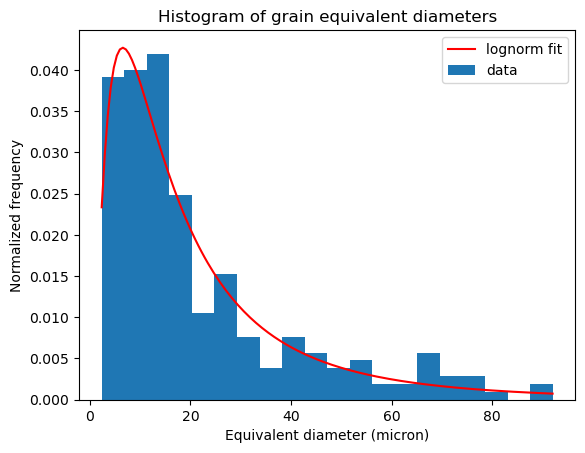

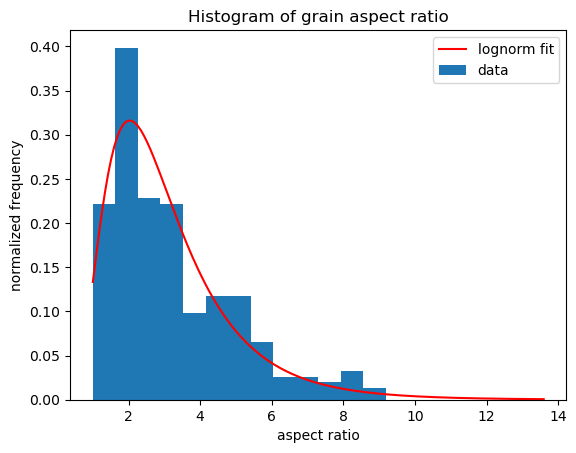

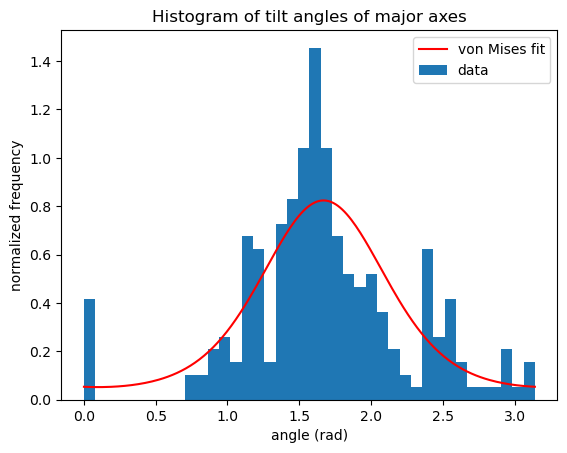

Analyzed microstructure of phase #0 (Iron fcc) with 245 grains.
Median values: equiv. diameter: 15.492 micron, aspect ratio: 2.71, tilt angle: 11.298°
Std. dev: equivalent diameter: 0.928 micron, aspect ratio: 0.538, tilt angle: 62.621°


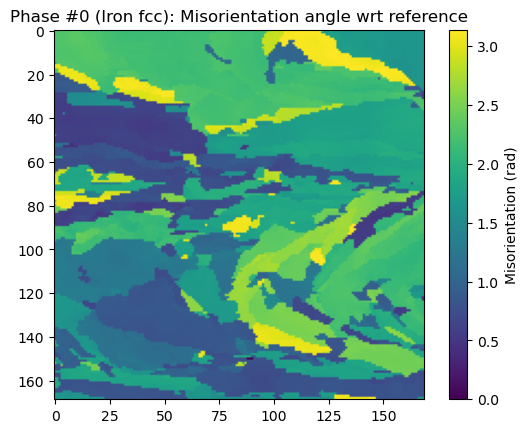

/mnt/c/Users/youse/kanapy/src/kanapy/texture.py:2195: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


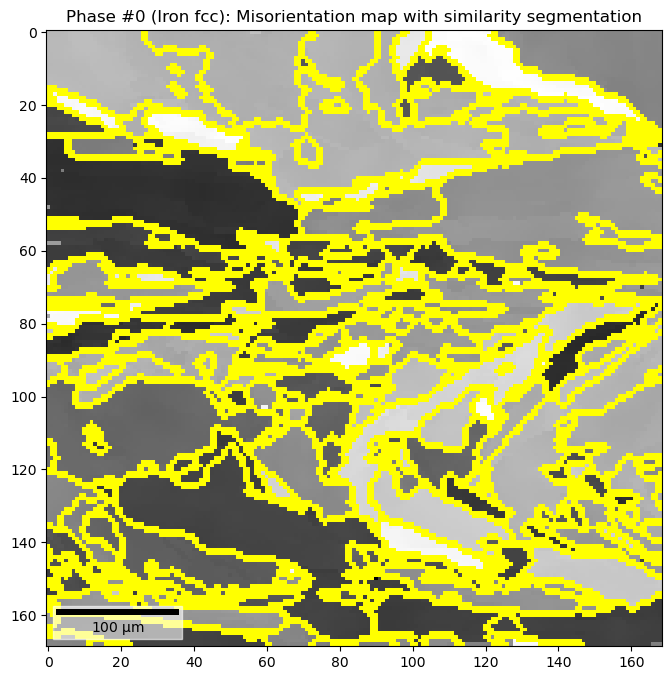

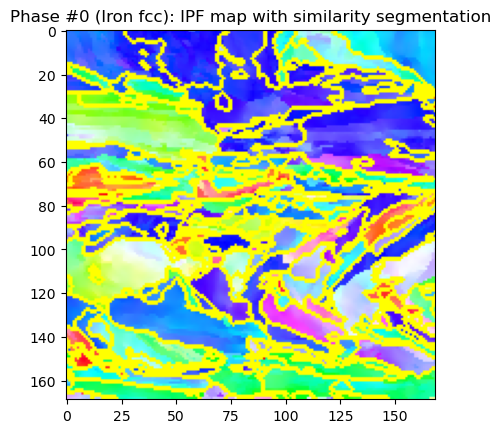

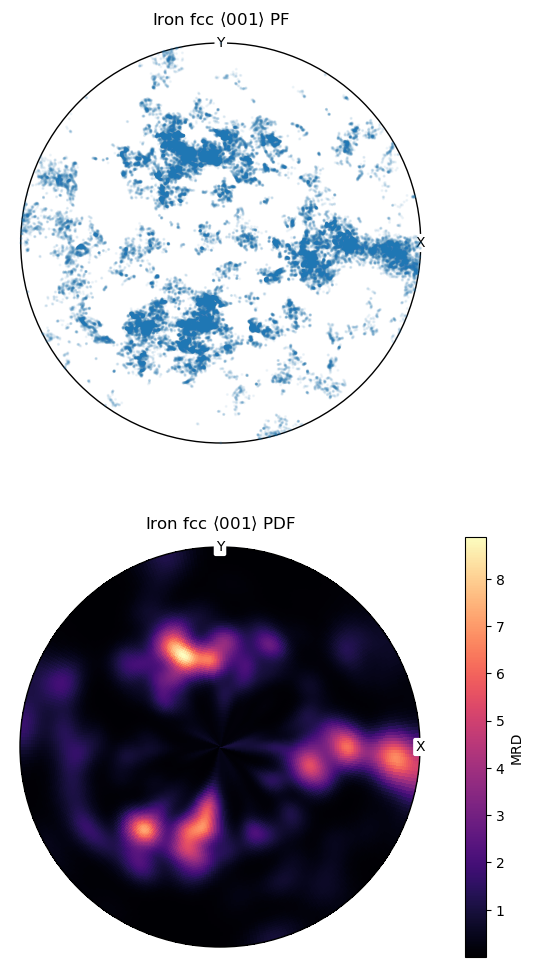

EBSD file loaded successfully!
  -> Current working directory: /home/yousef/damaskWorkflows/ebsd2kanapy2damask/Version13
  -> EBSD file: ebsd_316L_500x500.ang



EBSD map loading is completed ........................................................
########################################################################################



########################################################################################
Extracting microstructure statistics .................................................






Microstructure statistics extracting is completed .................................
#####################################################################################



########################################################################################
Generating RVE .......................................................................



Creating an RVE based on user defined statistics
    Analyzed statistical data for phase iron_fcc (0)
    Total number of par

100%|████████████████████████████████████████████████████████████████████████| 1441/1441 [00:09<00:00, 151.67it/s]


Actual final volume of ellipsoids: 2519.033027610848
Completed particle packing
37 overlapping particles detected after packing
Kinetic energy of particles after packing: 15786.476908755365






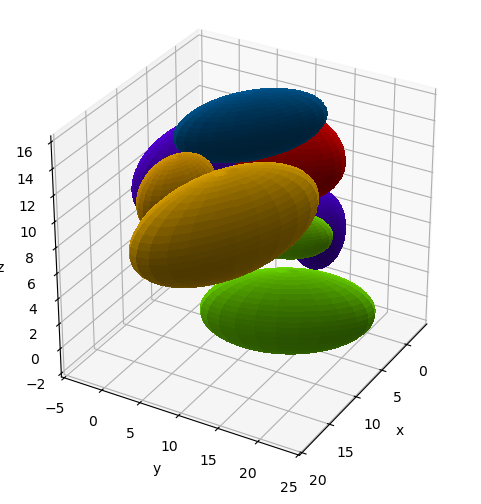

    Generating voxels inside RVE

Starting RVE voxelization
    Assigning voxels to grains


100%|████████████████████████████████████████████████████████████████████| 3375/3375 [00:00<00:00, 2281349.88it/s]


Completed RVE voxelization






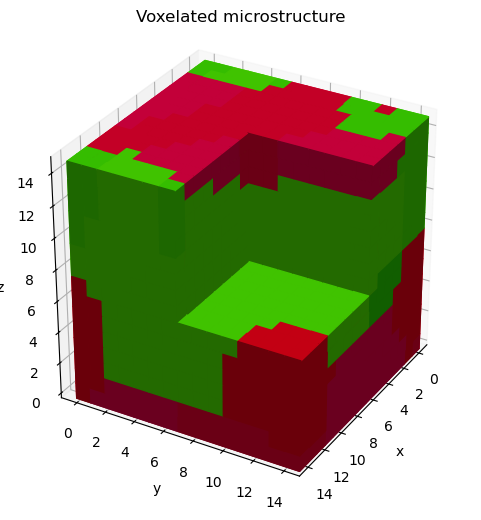

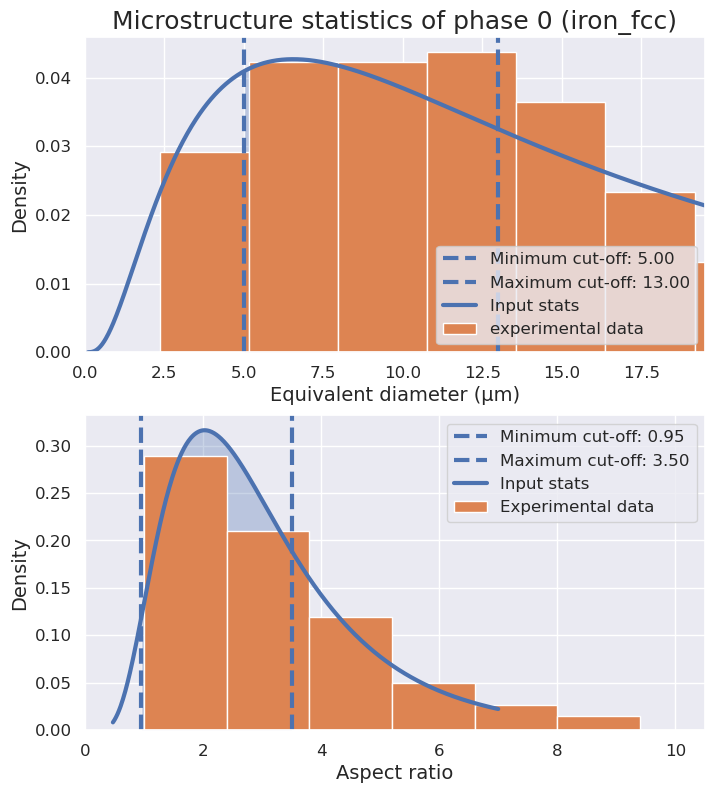

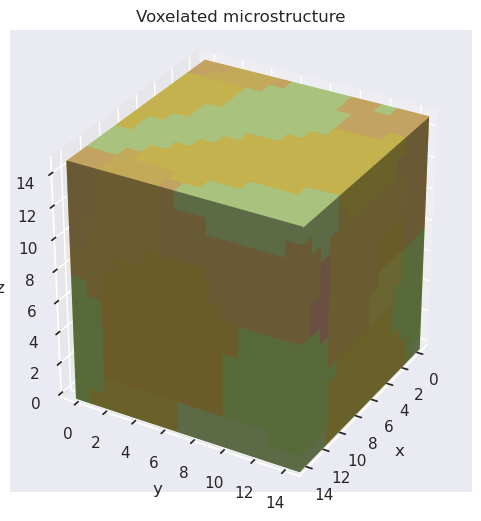




RVE generating is completed ........................................................
######################################################################################



########################################################################################
Exporting data .......................................................................



Saved to: /home/yousef/damaskWorkflows/ebsd2kanapy2damask/Version13/outputs/data_object.json



Data saved to JSON file ............................................................
######################################################################################



########################################################################################
Building grid/material/load from JSON ................................................



cells:  15 × 15 × 15
size:   1.4999999999999999e-05 × 1.4999999999999999e-05 × 1.4999999999999999e-05 m³
origin: 0.0   0.0   0.0 m
# materials: 8
grid file Saved to: /home/yousef/damaskWorkflow

/home/yousef/miniforge3/envs/damask/lib/python3.11/site-packages/quaternion/__init__.py:105: ComplexWarning: Casting complex values to real discards the imaginary part
  a = np.asarray(a, dtype=np.double)


Misorientation (deg): min/mean/max = 0.02032420389451458 5.988051162990178 52.91708425749159
=== STEP 1 COMPLETE ===

=== STEP 2: INITIAL CUT SEGMENTATION ===
TH_CUT (deg): 5.0
edges kept: 7235 edges cut: 2215
n_initial_segments: 55
largest 10 sizes: [2378, 205, 165, 115, 93, 67, 67, 43, 33, 31]
smallest 10 sizes: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
segments with <= 5 voxels: 36
=== STEP 2 COMPLETE ===

=== STEP 3: BUILD SEGMENT-RAG ===
segments: 55 labels min/max: 0 54
segment-RAG edges: 134

Top 10 neighbors by boundary contact count:
  seg 3 -- seg 6 : contacts=109, boundary_mean_miso_deg=36.443
  seg 3 -- seg 5 : contacts=107, boundary_mean_miso_deg=30.136
  seg 3 -- seg 27 : contacts=106, boundary_mean_miso_deg=46.224
  seg 3 -- seg 9 : contacts=61, boundary_mean_miso_deg=32.828
  seg 5 -- seg 6 : contacts=50, boundary_mean_miso_deg=42.665
  seg 3 -- seg 34 : contacts=44, boundary_mean_miso_deg=33.191
  seg 3 -- seg 38 : contacts=43, boundary_mean_miso_deg=28.962
  seg 3 -- seg 7 : con

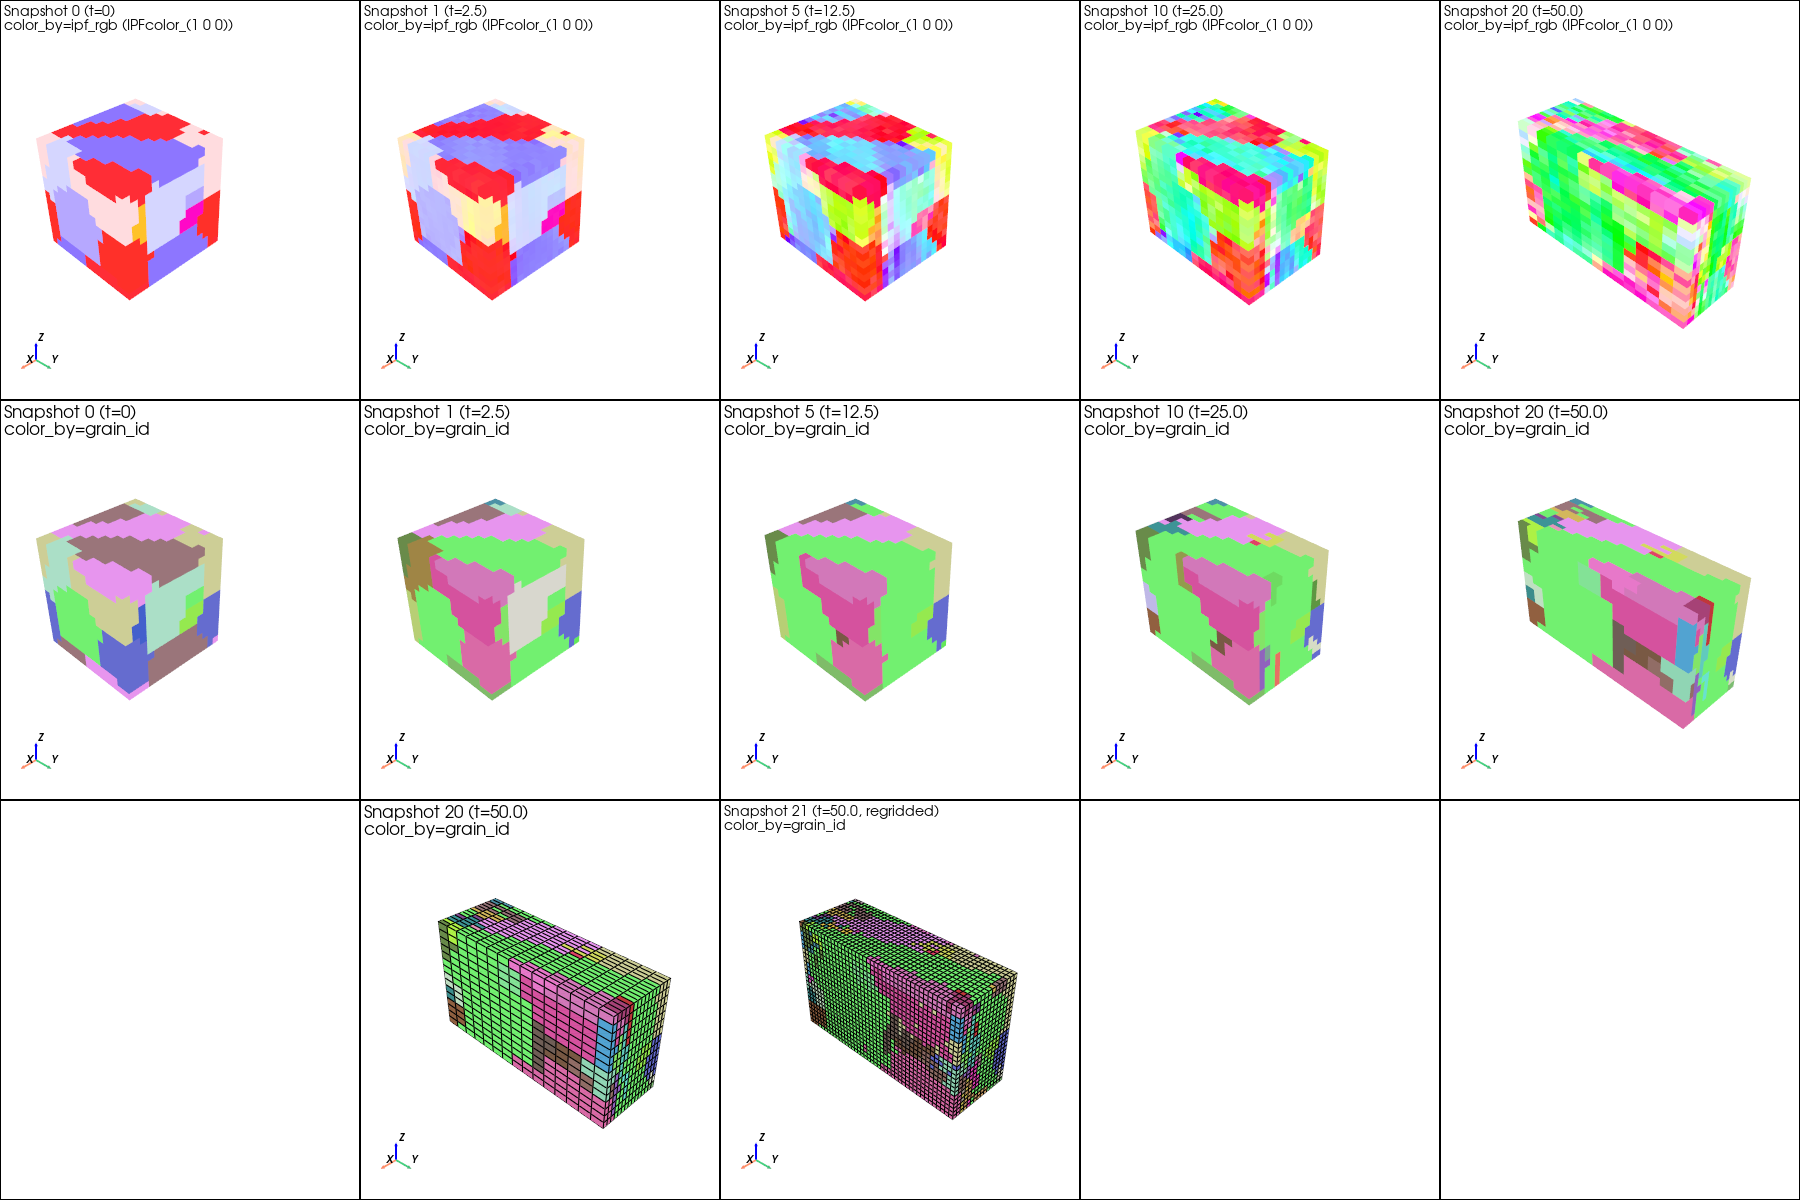




Microstructre is plotted ......................................................................
#################################################################################################



#################################################################################################
Extracting texture inputs .....................................................................


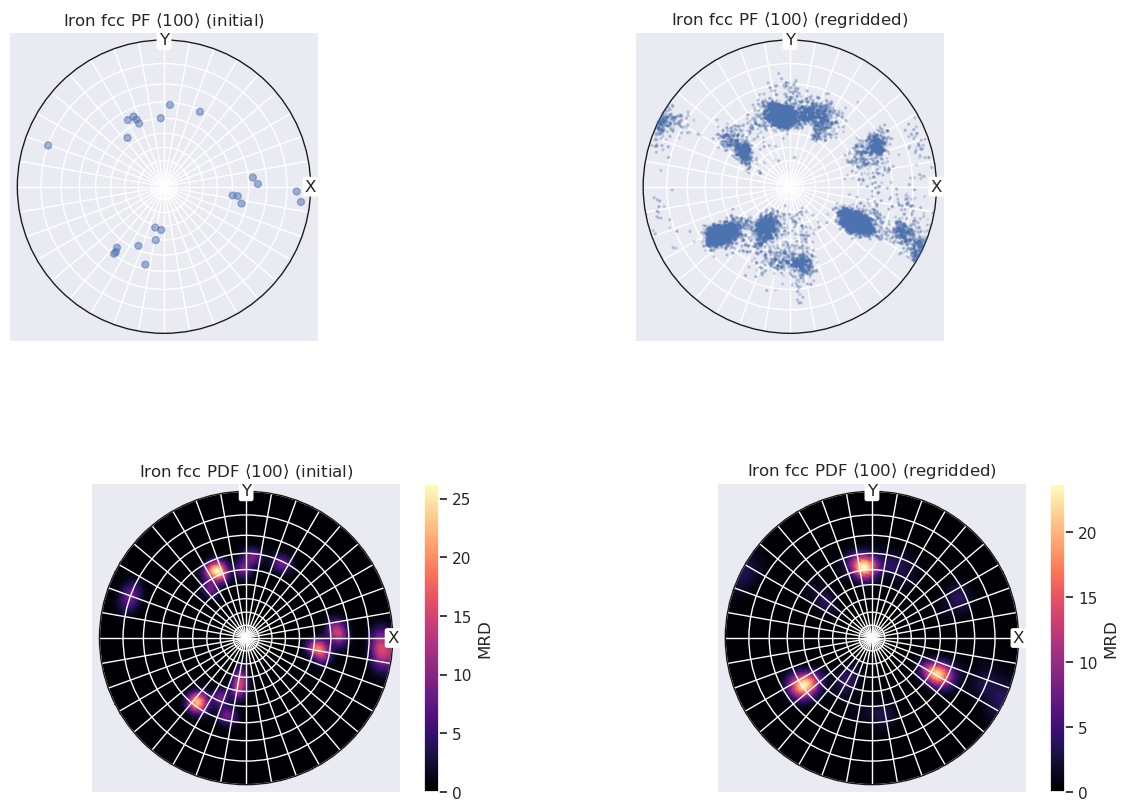




Extracting is completed .......................................................................
#################################################################################################



###################################################################################################
Extracting statistics from RVE ..................................................................





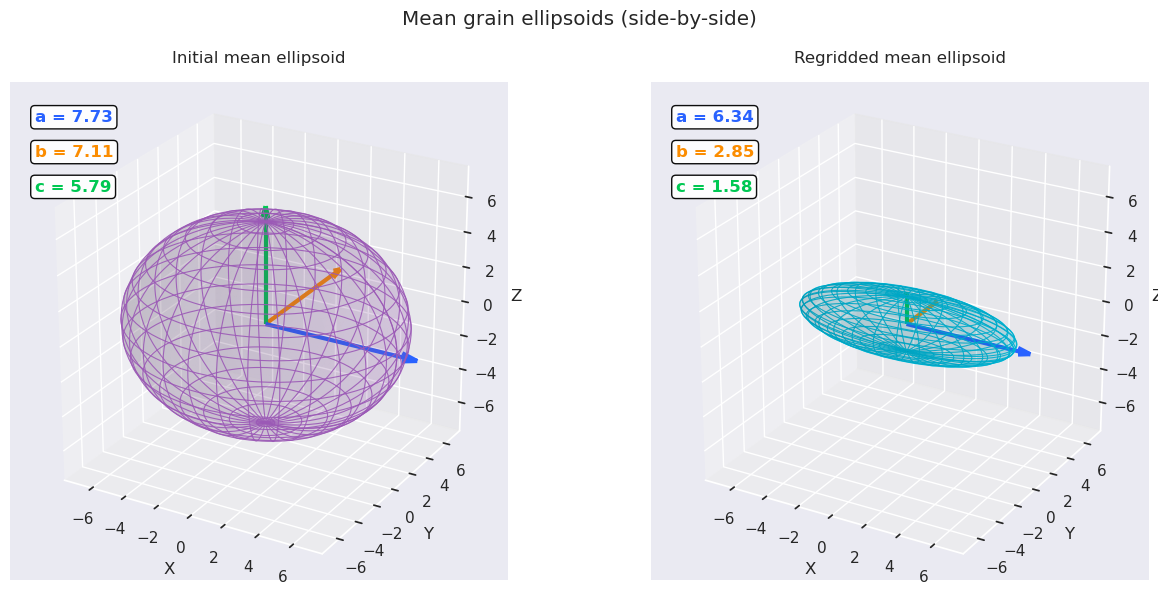

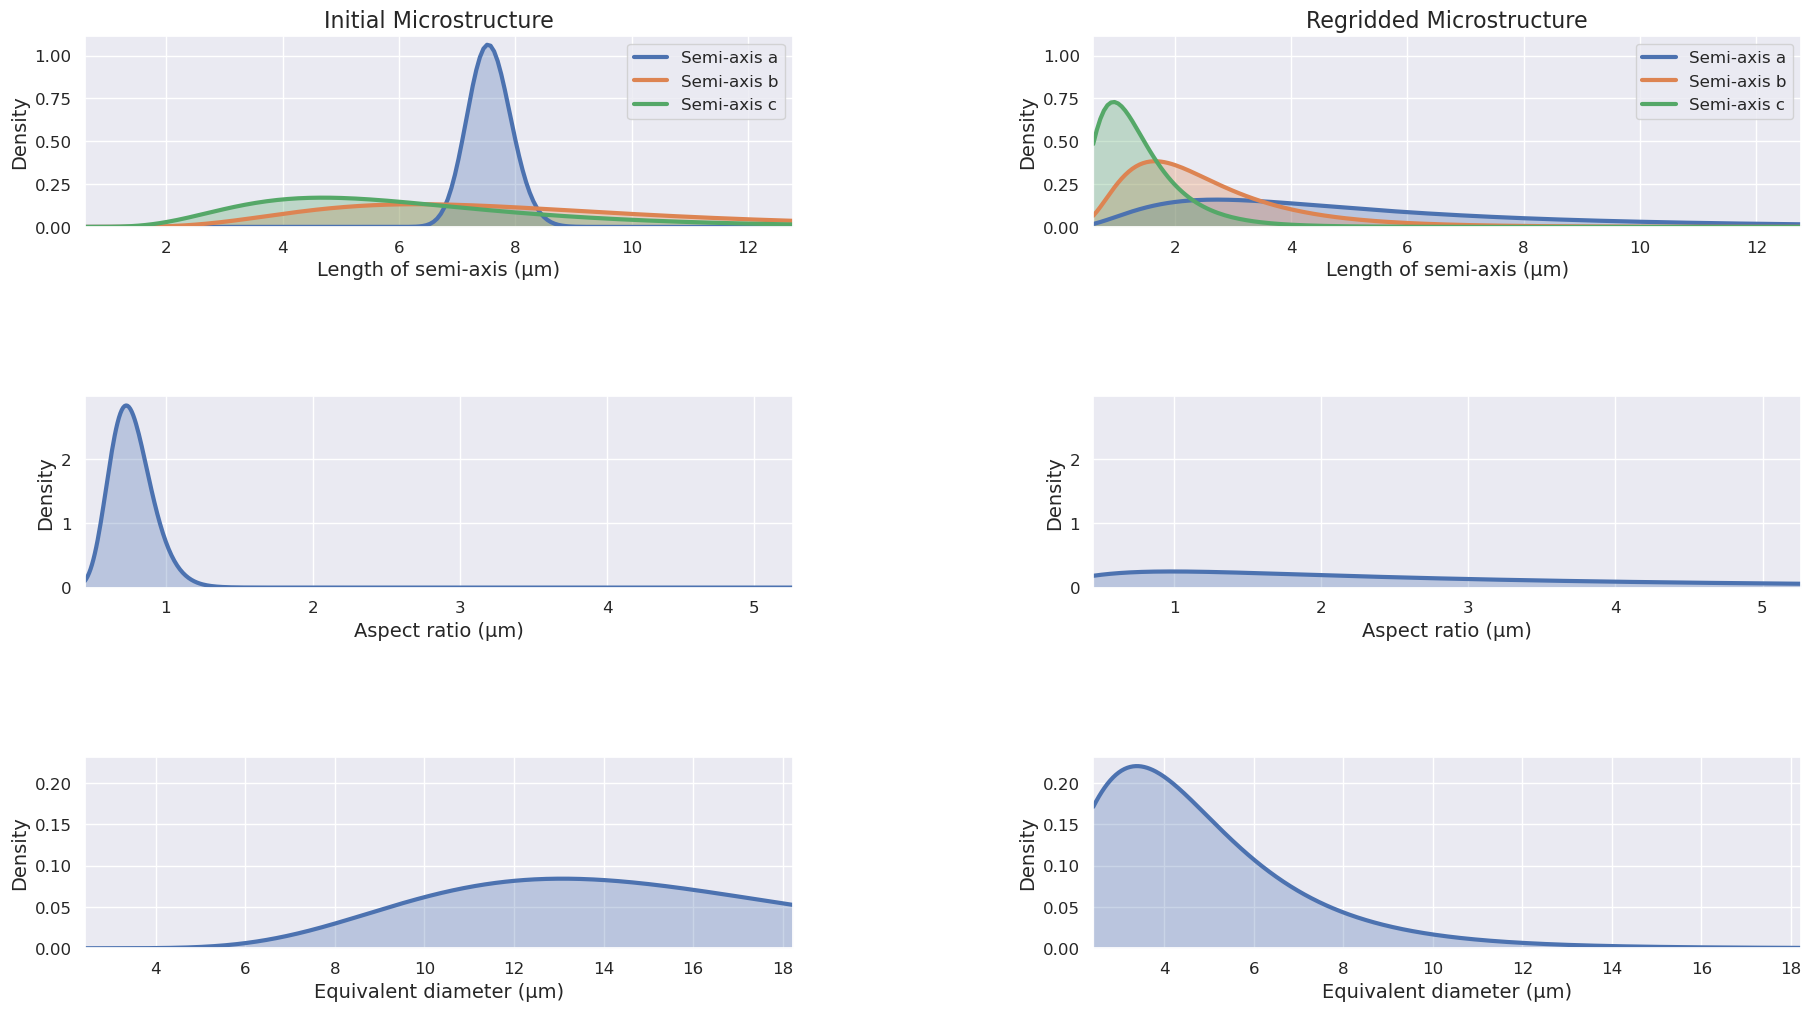




Extracting is completed .......................................................................
#################################################################################################



Workflow completed successfully. Json file has been generated.


In [15]:
try:
    wf.run() # Run the workflow
    print("Workflow completed successfully. Json file has been generated.")
except Exception as e:
    print(f"An error occurred during the workflow execution: {str(e)}")

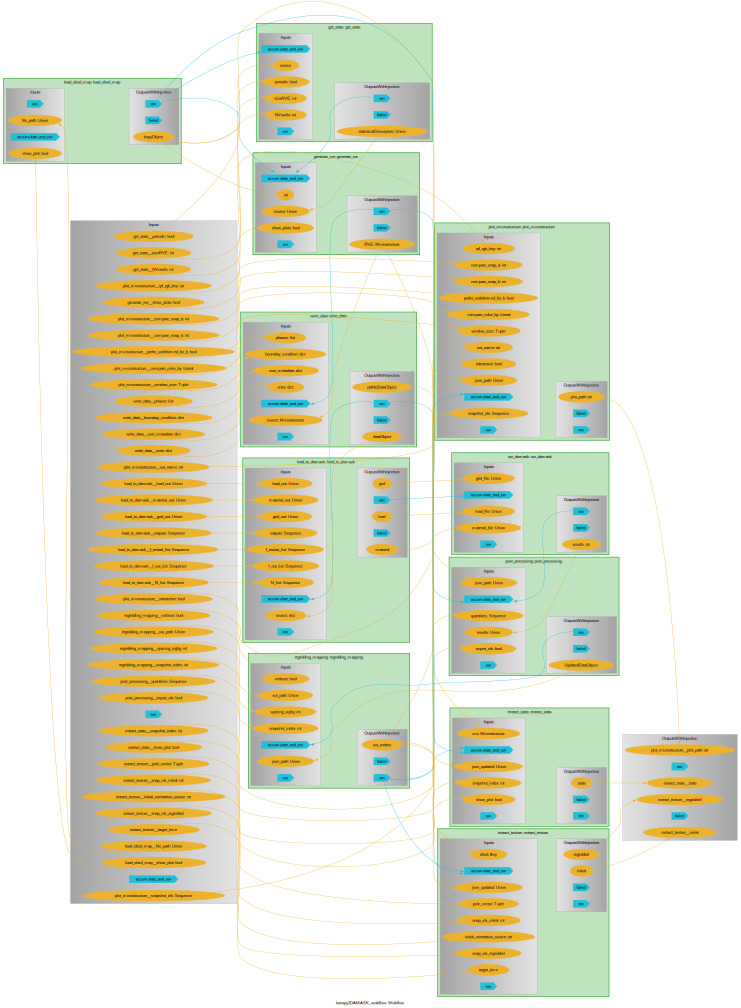

In [16]:
# Visualise the Kanapy→DAMASK workflow as a node graph
# (shows all steps, inputs, and dependencies at a glance)
wf.draw(size=(20, 14))

In [17]:
# Draw the workflow graph at larger size and capture the Graphviz object
workflow_graph = wf.draw(size=(15,15))

# Increase the resolution of the rendered figure
workflow_graph.graph_attr.update({'dpi': '600'}) 

# Ensure output directory for figures exists
outdir = Path("figures")
outdir.mkdir(exist_ok=True) 

# Base name (without extension) for the workflow diagram
outfile = outdir.joinpath("Kanapy2Damask Workflow")

# Render the workflow graph to a high-resolution PNG file
workflow_graph.render(filename=outfile, format="png")

'figures/Kanapy2Damask Workflow.png'

### <font style="font-family:roboto;color:#455e6c"> Conclusion </font>

This workflow demonstrates that a unified data schema can seamlessly connect Kanapy and DAMASK into a single, interoperable pipeline, enabling smooth data exchange, and FAIR-compliant 4D microstructure evolution datasets. Key takeaways:

- A unified schema eliminates incompatibilities between tools, allowing direct transfer of geometry, field data, and metadata.
- 2D characterization data is reconstructed in Kanapy into statistically equivalent 3D RVEs.
- These RVEs are exported—using the common schema—to the crystal-plasticity FFT solver for mechanical and microstructure evolution simulation.
- Simulation outputs are automatically remapped back into the Kanapy using the FAIR data object.
- The workflow integrates statistical descriptors, texture evolution, and remeshing results into a coherent, traceable 4D dataset aligned with FAIR principles.

Overall, the workflow establishes a continuous digital thread from microstructure reconstruction to property prediction, enabling reproducible and extensible multi-tool microstructure evolution studies.

<div class="admonition note" name="html-admonition" style="background:#e3f2fd; padding: 10px">
<font style="font-family:roboto;color:#455e6c;text-align:justify"> <a href="https://github.com/ICAMS/Kanapy">Kanapy</a> | <a href="https://damask-multiphysics.org/">DAMASK</a> | <a href="https://github.com/pyiron/pyiron_workflow">Pyiron_workflow</a>| <a href="https://nfdi-matwerk.de/">NFDI MatWerk</a> </font> </br>
</div>

### Guide to produced folders

<pre>
iutputs/
    |___ grid.vti                 — geometry file
    |___ load.yaml                — loading conditions
    |___ material.yaml            — material definitions


outputs/
    |___ VTK files                — field outputs from the DAMASK simulation (per increment)
    |___ results.hdf5             — full DAMASK results in HDF5 format
    |___ stats_data.json          — statistics of the initial and regridded microstructure
    |___ *.json                   — unified-schema files with metadata, mechanical fields,and voxel/grain-level microstructural data
    |___ run.log                  — terminal output of the DAMASK run (solver progress, warnings)

figures/
    |___ compare_microstructures.png      — comparison plots of initial vs. remeshed microstructure
    |___ Kanapy2Damask Workflow.png       — workflow diagram
    |___ stress_strain_per_grain.png      — per-grain stress–strain response
    |___ stress_strain.png                — overall stress–strain curve
</pre>